In [1760]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import date

# from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

print('Import Finished')

Import Finished


In [1761]:
#Reading in the data
X_train = pd.read_csv('dengue_features_train.csv')
y_train = pd.read_csv('dengue_labels_train.csv')
X_test = pd.read_csv('dengue_features_test.csv')
df_train = pd.concat([X_train, y_train.total_cases], axis = 1)

In [1762]:
X_train

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0      sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1      sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2      sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3      sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4      sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
...   ...   ...         ...             ...       ...       ...       ...   
1451   iq  2010          21      2010-05-28  0.342750  0.318900  0.256343   
1452   iq  2010          22      2010-06-04  0.160157  0.160371  0.136043   
1453   iq  2010          23      2010-06-11  0.247057  0.146057  0.250357   
1454   iq  2010          24      2010-06-18  0.333914  0.245771  0.278886   
1455   iq  2010          25      2010-06-25  0.298186  0.232971  0.274214   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
0     0.177617                 12.42             297.572857   
1     0.155486                 22.82             298.211429   
2     0.170843                 34.54             298.781429   
3     0.235886                 15.36             298.987143   
4     0.247340                  7.52             299.518571   
...        ...                   ...                    ...   
1451  0.292514                 55.30             299.334286   
1452  0.225657                 86.47             298.330000   
1453  0.233714                 58.94             296.598571   
1454  0.325486                 59.67             296.345714   
1455  0.315757                 63.22             298.097143   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0                297.742857                   292.414286   
1                298.442857                   293.951429   
2                298.878571                   295.434286   
3                299.228571                   295.310000   
4                299.664286                   295.821429   
...                     ...                          ...   
1451             300.771429                   296.825714   
1452             299.392857                   296.452857   
1453             297.592857                   295.501429   
1454             297.521429                   295.324286   
1455             299.835714                   295.807143   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                         299.8                      295.9   
1                         300.9                      296.4   
2                         300.5                      297.3   
3                         301.4                      297.0   
4                         301.9                      297.5   
...                         ...                        ...   
1451                      309.7                      294.5   
1452                      308.5                      291.9   
1453                      305.5                      292.4   
1454                      306.1                      291.9   
1455                      307.8                      292.3   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                               32.00                             73.365714   
1                               17.94                             77.368571   
2                               26.10                             82.052857   
3                               13.90                             80.337143   
4                               12.20                             80.460000   
...                               ...                                   ...   
1451                            45.00                             88.765714   
1452                           207.10                             91.600000   
1453                            50.60                             94.280000   
1454                            62.33                             9

In [1763]:
y_train

city  year  weekofyear  total_cases
0      sj  1990          18            4
1      sj  1990          19            5
2      sj  1990          20            4
3      sj  1990          21            3
4      sj  1990          22            6
...   ...   ...         ...          ...
1451   iq  2010          21            5
1452   iq  2010          22            8
1453   iq  2010          23            1
1454   iq  2010          24            1
1455   iq  2010          25            4

[1456 rows x 4 columns]

# EDA

In [1764]:
X_train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

All features provided are numeric, except for `city` and `week_start_date`

In [1766]:
#Splitting df_train, X_train, y_train, and X_test into two distinct datasets by city

df_train_sj = df_train.loc[df_train.city == 'sj']
df_train_iq = df_train.loc[df_train.city == 'iq']

X_train_sj = X_train.loc[X_train.city == 'sj']
X_train_iq = X_train.loc[X_train.city == 'iq']

y_train_sj = y_train.loc[y_train.city == 'sj'].join(X_train_sj['week_start_date'], how = 'left')
y_train_iq = y_train.loc[y_train.city == 'iq'].join(X_train_iq['week_start_date'], how = 'left')
y_train_labels_sj = y_train_sj.total_cases
y_train_labels_iq = y_train_iq.total_cases

X_test_sj = X_test.loc[X_test.city == 'sj']
X_test_iq = X_test.loc[X_test.city == 'iq']

Since the goal is to make accurate predictions for each city, we will create 2 separate models, one for each city.

In [1767]:
#Understanding the training dataset

n_sj = X_train_sj.city.count()
n_iq = X_train_iq.city.count()

earliest_date_sj = X_train_sj.week_start_date.min()
latest_date_sj = X_train_sj.week_start_date.max()

earliest_date_iq = X_train_iq.week_start_date.min()
latest_date_iq = X_train_iq.week_start_date.max()

print('Of the total {} training data points provided, {} belong to SJ and the remaining {} belong to IQ'.format(X_train.city.count(), n_sj, n_iq))
print()
print('In the training set, the dates provided for SJ range from {} to {}. The dates provided for IQ range from {} to {}'.format(earliest_date_sj, latest_date_sj, earliest_date_iq, latest_date_iq))

Of the total 1456 training data points provided, 936 belong to SJ and the remaining 520 belong to IQ

In the training set, the dates provided for SJ range from 1990-04-30 to 2008-04-22. The dates provided for IQ range from 2000-07-01 to 2010-06-25


In [1768]:
X_train_sj.describe()

year  weekofyear     ndvi_ne     ndvi_nw     ndvi_se  \
count   936.000000  936.000000  745.000000  887.000000  917.000000   
mean   1998.826923   26.503205    0.057925    0.067469    0.177655   
std       5.212076   15.021909    0.107153    0.092479    0.057166   
min    1990.000000    1.000000   -0.406250   -0.456100   -0.015533   
25%    1994.000000   13.750000    0.004500    0.016425    0.139283   
50%    1999.000000   26.500000    0.057700    0.068075    0.177186   
75%    2003.000000   39.250000    0.111100    0.115200    0.212557   
max    2008.000000   53.000000    0.493400    0.437100    0.393129   

          ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  917.000000            927.000000             930.000000   
mean     0.165956             35.470809             299.163653   
std      0.056073             44.606137               1.236429   
min     -0.063457              0.000000             295.938571   
25%      0.129157              0.000000             298.195000   
50%      0.165971             20.800000             299.254286   
75%      0.202771             52.180000             300.132857   
max      0.381420            390.600000             302.200000   

       reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
count             930.000000                   930.000000   
mean              299.276920                   295.109519   
std                 1.218637                     1.569943   
min               296.114286                   289.642857   
25%               298.300000                   293.847857   
50%               299.378571                   295.464286   
75%               300.228571                   296.418929   
max               302.164286                   297.795714   

       reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
count                 930.000000                 930.000000   
mean                  301.398817                 297.301828   
std                     1.258927                   1.294705   
min                   297.800000                 292.600000   
25%                   300.400000                 296.300000   
50%                   301.500000                 297.500000   
75%                   302.400000                 298.400000   
max                   304.300000                 299.900000   

       reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
count                       930.000000                            930.000000   
mean                         30.465419                             78.568181   
std                          35.628055                              3.389488   
min                           0.000000                             66.735714   
25%                          10.825000                             76.246071   
50%                          21.300000                             78.667857   
75%                          37.000000                             80.963214   
max                         570.500000                             87.575714   

       reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
count                    927.000000                             930.000000   
mean                      35.470809                              16.552409   
std                       44.606137                               1.560923   
min                        0.000000                              11.715714   
25%                        0.000000                              15.236429   
50%                       20.800000                              16.845714   
75%                       52.180000                              17.858571   
max                      390.600000                              19.440000   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count         930.000000          930.000000               930.000000   
mean            2.516267           27.006528                 6.757373   
std             0.498892   

In [1769]:
X_train_iq.describe()

year  weekofyear     ndvi_ne     ndvi_nw     ndvi_se  \
count   520.000000  520.000000  517.000000  517.000000  517.000000   
mean   2005.000000   26.503846    0.263869    0.238783    0.250126   
std       2.918283   15.029450    0.081370    0.076751    0.077354   
min    2000.000000    1.000000    0.061729    0.035860    0.029880   
25%    2002.750000   13.750000    0.200000    0.179540    0.194743   
50%    2005.000000   26.500000    0.263643    0.232971    0.249800   
75%    2007.250000   39.250000    0.319971    0.293929    0.302300   
max    2010.000000   53.000000    0.508357    0.454429    0.538314   

          ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  517.000000            516.000000             516.000000   
mean     0.266779             64.245736             297.869538   
std      0.086345             35.218995               1.170997   
min      0.064183              0.000000             294.635714   
25%      0.204129             39.105000             297.092500   
50%      0.262143             60.470000             297.822857   
75%      0.325150             85.757500             298.649286   
max      0.546017            210.830000             301.637143   

       reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
count             516.000000                   516.000000   
mean              299.133043                   295.492982   
std                 1.332073                     1.417229   
min               294.892857                   290.088571   
25%               298.221429                   294.593929   
50%               299.121429                   295.852143   
75%               300.123214                   296.548571   
max               302.928571                   298.450000   

       reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
count                 516.000000                 516.000000   
mean                  307.082752                 292.866667   
std                     2.382980                   1.663069   
min                   300.000000                 286.900000   
25%                   305.200000                 291.975000   
50%                   307.050000                 293.050000   
75%                   308.700000                 294.200000   
max                   314.000000                 296.000000   

       reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
count                       516.000000                            516.000000   
mean                         57.609864                             88.639117   
std                          50.286555                              7.583889   
min                           0.000000                             57.787143   
25%                          24.065000                             84.295000   
50%                          46.440000                             90.917143   
75%                          71.072500                             94.563929   
max                         362.030000                             98.610000   

       reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
count                    516.000000                             516.000000   
mean                      64.245736                              17.096110   
std                       35.218995                               1.445769   
min                        0.000000                              12.111429   
25%                       39.105000                              16.102857   
50%                       60.470000                              17.428571   
75%                       85.757500                              18.180357   
max                      210.830000                              20.461429   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count         516.000000          483.000000               483.000000   
mean            9.206783           27.530933                10.566197   
std             2.448525   

In [1770]:
y_train_sj.describe()

year  weekofyear  total_cases
count   936.000000  936.000000   936.000000
mean   1998.826923   26.503205    34.180556
std       5.212076   15.021909    51.381372
min    1990.000000    1.000000     0.000000
25%    1994.000000   13.750000     9.000000
50%    1999.000000   26.500000    19.000000
75%    2003.000000   39.250000    37.000000
max    2008.000000   53.000000   461.000000

In [1771]:
y_train_iq.describe()

year  weekofyear  total_cases
count   520.000000  520.000000   520.000000
mean   2005.000000   26.503846     7.565385
std       2.918283   15.029450    10.765478
min    2000.000000    1.000000     0.000000
25%    2002.750000   13.750000     1.000000
50%    2005.000000   26.500000     5.000000
75%    2007.250000   39.250000     9.000000
max    2010.000000   53.000000   116.000000

In [1772]:
X_train_iq

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
936    iq  2000          26      2000-07-01  0.192886  0.132257  0.340886   
937    iq  2000          27      2000-07-08  0.216833  0.276100  0.289457   
938    iq  2000          28      2000-07-15  0.176757  0.173129  0.204114   
939    iq  2000          29      2000-07-22  0.227729  0.145429  0.254200   
940    iq  2000          30      2000-07-29  0.328643  0.322129  0.254371   
...   ...   ...         ...             ...       ...       ...       ...   
1451   iq  2010          21      2010-05-28  0.342750  0.318900  0.256343   
1452   iq  2010          22      2010-06-04  0.160157  0.160371  0.136043   
1453   iq  2010          23      2010-06-11  0.247057  0.146057  0.250357   
1454   iq  2010          24      2010-06-18  0.333914  0.245771  0.278886   
1455   iq  2010          25      2010-06-25  0.298186  0.232971  0.274214   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
936   0.247200                 25.41             296.740000   
937   0.241657                 60.61             296.634286   
938   0.128014                 55.52             296.415714   
939   0.200314                  5.60             295.357143   
940   0.361043                 62.76             296.432857   
...        ...                   ...                    ...   
1451  0.292514                 55.30             299.334286   
1452  0.225657                 86.47             298.330000   
1453  0.233714                 58.94             296.598571   
1454  0.325486                 59.67             296.345714   
1455  0.315757                 63.22             298.097143   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
936              298.450000                   295.184286   
937              298.428571                   295.358571   
938              297.392857                   295.622857   
939              296.228571                   292.797143   
940              297.635714                   293.957143   
...                     ...                          ...   
1451             300.771429                   296.825714   
1452             299.392857                   296.452857   
1453             297.592857                   295.501429   
1454             297.521429                   295.324286   
1455             299.835714                   295.807143   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
936                       307.3                      293.1   
937                       306.6                      291.1   
938                       304.5                      292.6   
939                       303.6                      288.6   
940                       307.0                      291.5   
...                         ...                        ...   
1451                      309.7                      294.5   
1452                      308.5                      291.9   
1453                      305.5                      292.4   
1454                      306.1                      291.9   
1455                      307.8                      292.3   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
936                             43.19                             92.418571   
937                             46.00                             93.581429   
938                             64.77                             95.848571   
939                             23.96                             87.234286   
940                             31.80                             88.161429   
...                               ...                                   ...   
1451                            45.00                             88.765714   
1452                           207.10                             91.600000   
1453                            50.60                             94.280000   
1454                            62.33                             9

In [1773]:
y_train_iq

city  year  weekofyear  total_cases week_start_date
936    iq  2000          26            0      2000-07-01
937    iq  2000          27            0      2000-07-08
938    iq  2000          28            0      2000-07-15
939    iq  2000          29            0      2000-07-22
940    iq  2000          30            0      2000-07-29
...   ...   ...         ...          ...             ...
1451   iq  2010          21            5      2010-05-28
1452   iq  2010          22            8      2010-06-04
1453   iq  2010          23            1      2010-06-11
1454   iq  2010          24            1      2010-06-18
1455   iq  2010          25            4      2010-06-25

[520 rows x 5 columns]

#### Missing Data

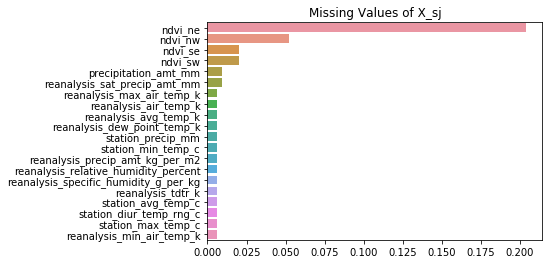

In [1774]:
# Percent of values missing from each variable (SJ)

x = (X_train_sj.iloc[:, 4:].isnull().sum() / len(X_train_sj)).sort_values(ascending=False)
y = x.index
sns.barplot(x = x, y = y)
plt.title('Missing Values of X_sj')
plt.show()

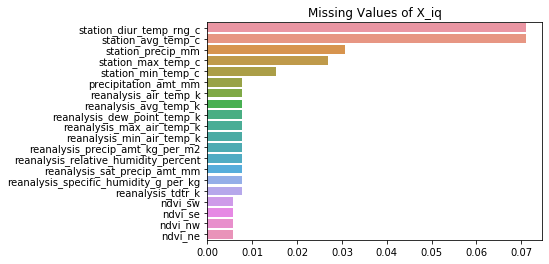

In [1775]:
# Percent of values missing from each variable (IQ)

x = (X_train_iq.iloc[:, 4:].isnull().sum() / len(X_train_iq)).sort_values(ascending=False)
y = x.index
sns.barplot(x = x, y = y)
plt.title('Missing Values of X_iq')
plt.show()

In SJ, the NDVI variables have the highest percent of missing data. All other variables are missing less than 1% of values. In IQ, the five station variables are missing anywhere from 1.5% to 7.1% of their values. 

In [1776]:
# Examining data points with NaN for all climate-related variables (SJ)

X_train_sj[X_train_sj.iloc[:, 4:].isnull().all(axis=1)]

city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw  ndvi_se  \
139   sj  1993          53      1993-01-01      NaN      NaN      NaN   
451   sj  1999          53      1999-01-01      NaN      NaN      NaN   
763   sj  2005          53      2005-01-01      NaN      NaN      NaN   

     ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
139      NaN                   NaN                    NaN   
451      NaN                   NaN                    NaN   
763      NaN                   NaN                    NaN   

     reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
139                    NaN                          NaN   
451                    NaN                          NaN   
763                    NaN                          NaN   

     reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
139                        NaN                        NaN   
451                        NaN                        NaN   
763                        NaN                        NaN   

     reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
139                              NaN                                   NaN   
451                              NaN                                   NaN   
763                              NaN                                   NaN   

     reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
139                           NaN                                    NaN   
451                           NaN                                    NaN   
763                           NaN                                    NaN   

     reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
139                NaN                 NaN                      NaN   
451                NaN                 NaN                      NaN   
763                NaN                 NaN                      NaN   

     station_max_temp_c  station_min_temp_c  station_precip_mm  
139                 NaN                 NaN                NaN  
451                 NaN                 NaN                NaN  
763                 NaN                 NaN                NaN

In [1777]:
# Examining data points with NaN for all climate-related variables (IQ)

X_train_iq[X_train_iq.iloc[:, 4:].isnull().all(axis=1)]

city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw  ndvi_se  \
1170   iq  2005          53      2005-01-01      NaN      NaN      NaN   
1430   iq  2010          53      2010-01-01      NaN      NaN      NaN   

      ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
1170      NaN                   NaN                    NaN   
1430      NaN                   NaN                    NaN   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
1170                    NaN                          NaN   
1430                    NaN                          NaN   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
1170                        NaN                        NaN   
1430                        NaN                        NaN   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
1170                              NaN                                   NaN   
1430                              NaN                                   NaN   

      reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
1170                           NaN                                    NaN   
1430                           NaN                                    NaN   

      reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
1170                NaN                 NaN                      NaN   
1430                NaN                 NaN                      NaN   

      station_max_temp_c  station_min_temp_c  station_precip_mm  
1170                 NaN                 NaN                NaN  
1430                 NaN                 NaN                NaN

In [1778]:
X_train_sj[X_train_sj.year == 2004][['weekofyear', 'week_start_date']]

weekofyear week_start_date
711           1      2004-01-01
712           2      2004-01-08
713           3      2004-01-15
714           4      2004-01-22
715           5      2004-01-29
..          ...             ...
758          48      2004-11-25
759          49      2004-12-02
760          50      2004-12-09
761          51      2004-12-16
762          52      2004-12-23

[52 rows x 2 columns]

In [1779]:
X_train_sj[X_train_sj.year == 2005][['weekofyear', 'week_start_date']]

weekofyear week_start_date
763          53      2005-01-01
764           1      2005-01-08
765           2      2005-01-15
766           3      2005-01-22
767           4      2005-01-29
..          ...             ...
810          47      2005-11-26
811          48      2005-12-03
812          49      2005-12-10
813          50      2005-12-17
814          51      2005-12-24

[52 rows x 2 columns]

In [1780]:
X_train.groupby(['city', 'year']).weekofyear.count().reset_index(level=['city']).pivot(columns = 'city')

weekofyear      
city         iq    sj
year                 
1990        NaN  35.0
1991        NaN  52.0
1992        NaN  52.0
1993        NaN  52.0
1994        NaN  52.0
1995        NaN  52.0
1996        NaN  52.0
1997        NaN  52.0
1998        NaN  52.0
1999        NaN  52.0
2000       26.0  52.0
2001       52.0  52.0
2002       52.0  52.0
2003       52.0  52.0
2004       52.0  52.0
2005       52.0  52.0
2006       52.0  52.0
2007       52.0  52.0
2008       52.0  17.0
2009       52.0   NaN
2010       26.0   NaN

Week 53 occurrs in `weekofyear` in some years is due to the ISO standard. All `weekofyear` values of 53 have a `week_start_date` of 01/01 and contain 52 total weeks, with the last week being 51. All years, except for those at the beginning and end of the dataset for each city (1990 and 2008 for SJ, 2000 and 2010 for IQ) contain 52 weeks. Feature engineering `weekofyear` so that 53 becomes 1 and all others are increased by 1.

In [1781]:
# station_cols = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
# station_cols
# df_missing_iq.station_avg_temp_c

In [1782]:
#Proportion of station variables that have NaN as value when a given station variable is NaN

# prop_na = {}
# station_cols = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
# for col in station_cols:
#     for col2 in station_cols:
#         #for each specific variable, only calculating proportion for variables whose NaN count is greater than or equal to the variable at hand
#         if col != col2 and df_missing_iq[col].count() >= df_missing_iq[col2].count():
#             prop_na[(col, col2)] = 1 - df_missing_iq[df_missing_iq[col].isnull()][col2].count() / len(df_missing_iq[df_missing_iq[col].isnull()])
# prop_na

Given that many of these proportions are near or at 1, this indicates that when a value in one of the station-related variables is missing, it is likely missing across all for a given date. 

#### Distributions of variables and relationship to total cases

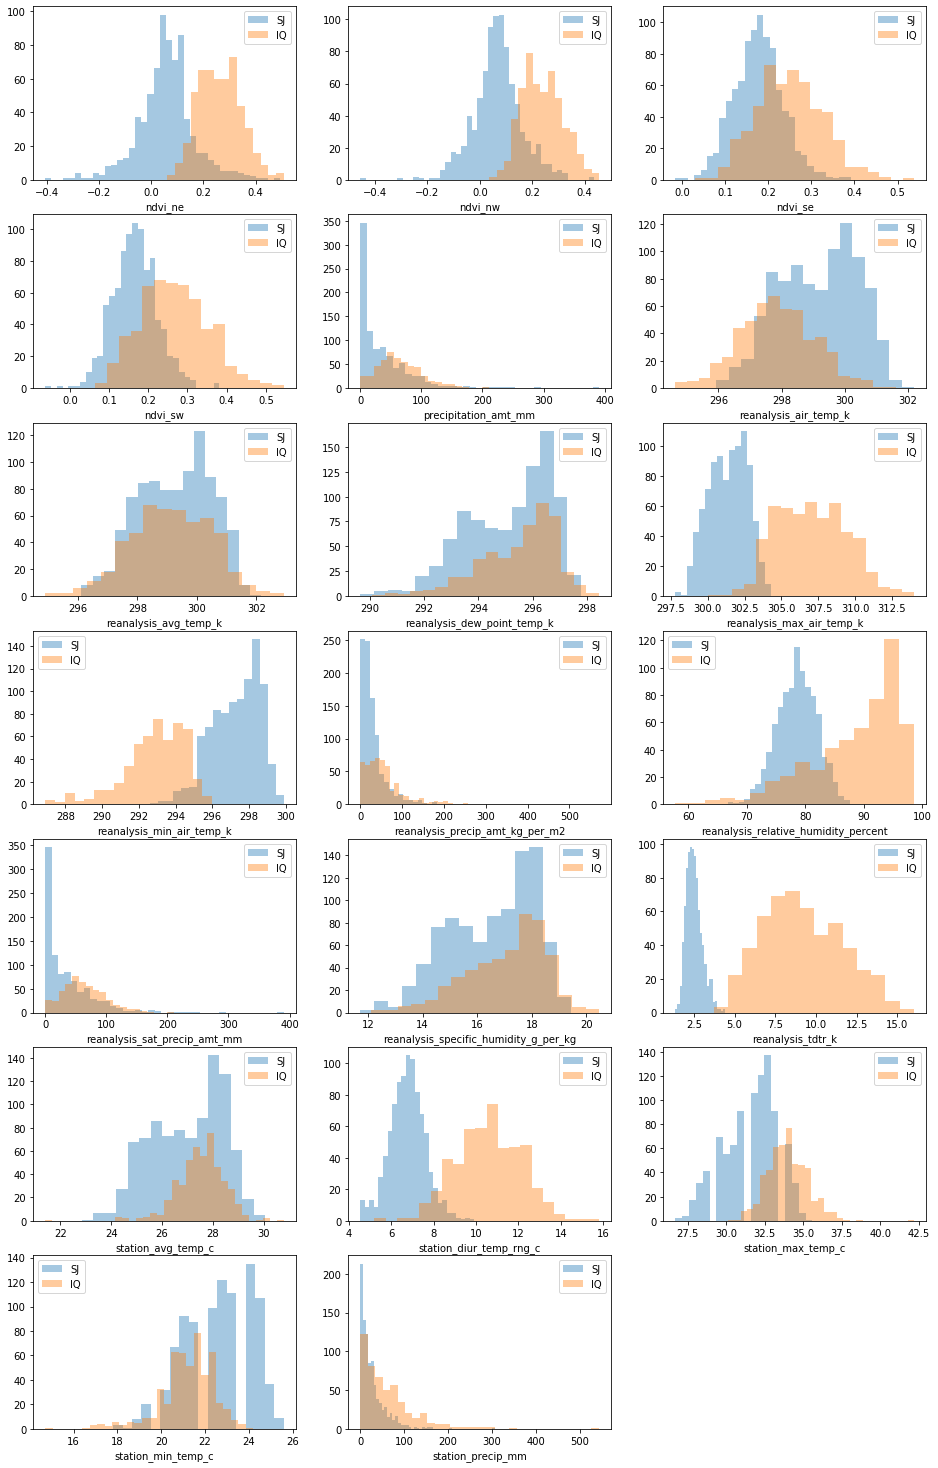

In [1783]:
#Distribution of values of each variable by city

fig = plt.figure(figsize=(16,30))
i = 0
for col in X_train.columns[4:]:
    i+=1
    fig.add_subplot(8,3,i)
    sns.distplot(a=X_train_sj[X_train_sj[col].notnull()][col], kde = False, label = 'SJ')
    sns.distplot(a=X_train_iq[X_train_iq[col].notnull()][col], kde = False, label = 'IQ')
    plt.legend()

Examining these histograms, we are able to see how the two cities differ. For example, `precipitation_amount_mm` for SJ is highly concentrated at 0 whereas it is more evenly distributed around 60 for IQ. The long tail of `precipitation_amount_mm` in SJ could indicate that a rainy and dry season exist. NDVI stands for normalized vegetation difference index and measures the density of green on a patch of land. Values range from -1 to 1, where 1 is fully green and 0 is no vegetation. IQ has higher indeces than SJ across all four pixels. 

These historgrams also provide insight into feature characteristics as well. Some of these features measure the same or correlated attributes. For example, `reanalysis_sat_precip_amt_mm` and `station_precip_mm` measure total precipitation in the city but come from different sources. As mentioned previously `precipitation_amount_mm` for SJ is highly concentrated at 0 and therefore our model may benefit from a transformation. As a result, we will likely be able to improve our model's performance by utilizing feature engineering and/or feature selection.

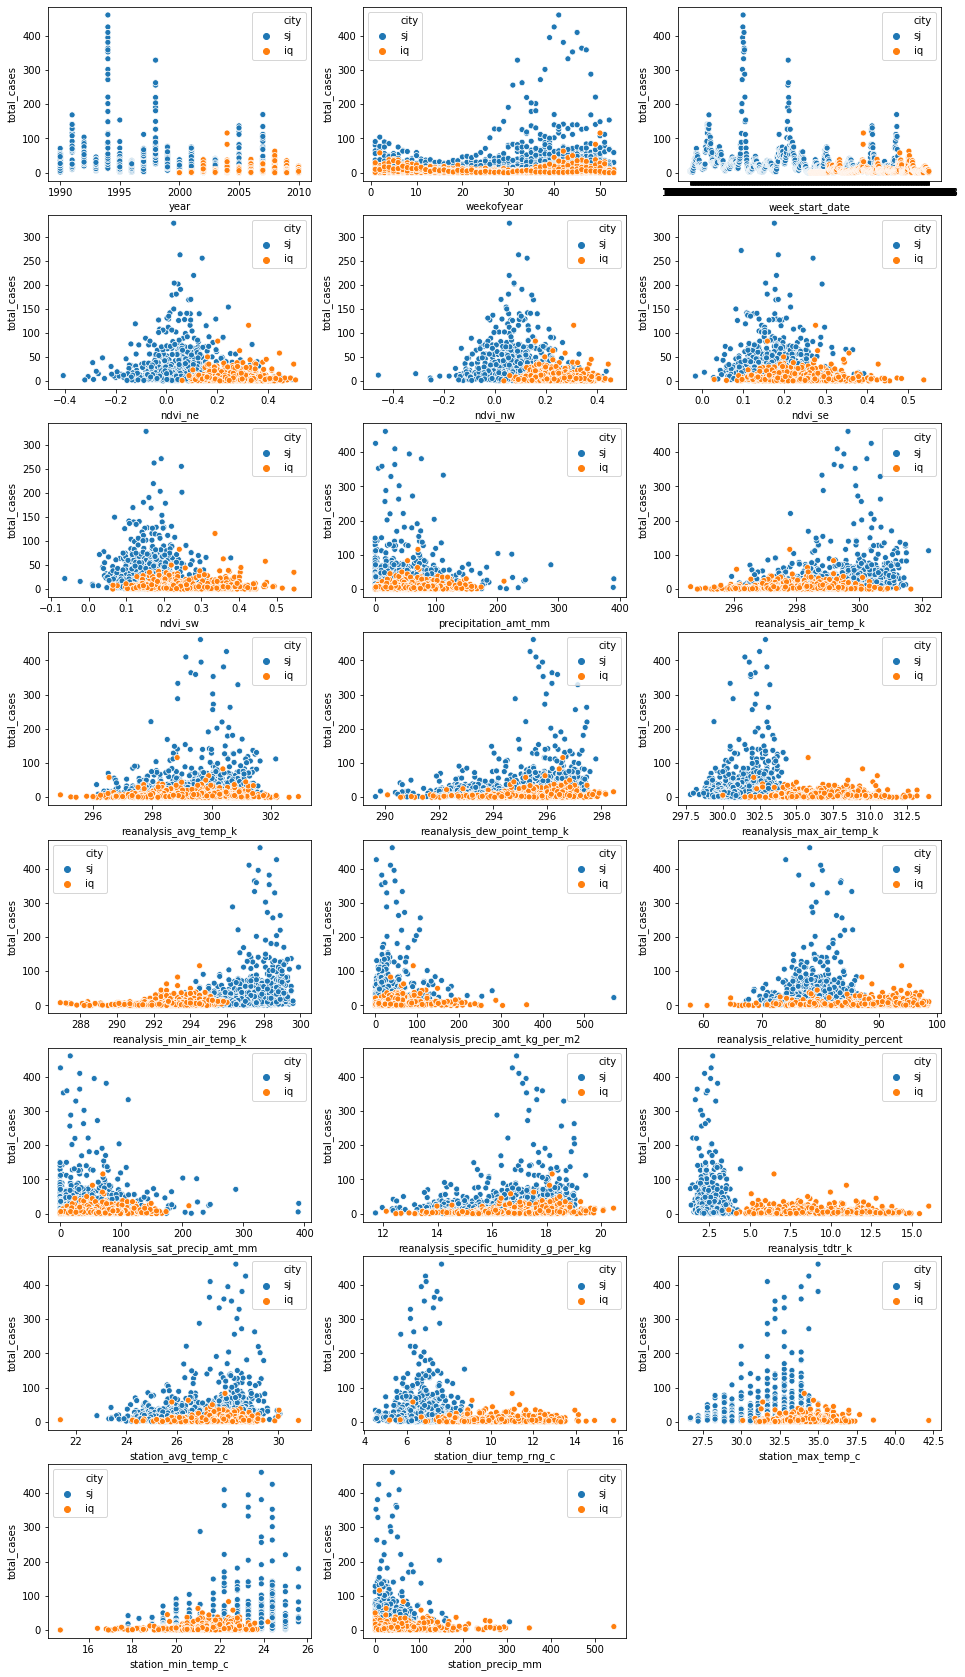

In [1784]:
#Pairwise plots of each variable by city

fig = plt.figure(figsize=(16,30))
i = 0
for col in X_train_sj.columns.drop('city'):
    i += 1
    fig.add_subplot(8,3,i)
    sns.scatterplot(x=df_train[col], y=df_train["total_cases"], hue = df_train['city'])

The scatterplots show that SJ has much higher `total_cases` numbers than does IQ (the average number of weekly cases in the training set in SJ was 34 compared to 8 in IQ as shown in the tables above). From this visual perspective, it appears that the variables' effects on `total_cases` is similar in both cities, which falls inline with our understanding of the disease. 

#### SJ Correlations Exploration

In [1785]:
#Correlation of variables with total_cases in SJ

df_train_sj.corr()['total_cases'].sort_values()

year                                    -0.212690
reanalysis_tdtr_k                       -0.067600
ndvi_sw                                 -0.000333
ndvi_se                                  0.001113
station_diur_temp_rng_c                  0.034630
ndvi_ne                                  0.037639
station_precip_mm                        0.051759
precipitation_amt_mm                     0.060211
reanalysis_sat_precip_amt_mm             0.060211
ndvi_nw                                  0.075307
reanalysis_precip_amt_kg_per_m2          0.107457
reanalysis_relative_humidity_percent     0.144045
reanalysis_avg_temp_k                    0.175267
station_min_temp_c                       0.177012
reanalysis_air_temp_k                    0.181917
reanalysis_min_air_temp_k                0.187943
station_max_temp_c                       0.189901
reanalysis_max_air_temp_k                0.194532
station_avg_temp_c                       0.196617
reanalysis_dew_point_temp_k              0.203774


None of the variables strongly correlate with `total_cases` and all but three of the correlations are positive. Also, `weekofyear`, which in a way encapsulates many of these variables, is surprisingly the strongest predictor. Temperature and humidity-related variables somewhat strongly correlate with `total_cases` whereas precipitation-related and NDVI variables are weak correlators. The weak correlation of precipitation-related variables in SJ could be related to the high number of weeks with 0 values.

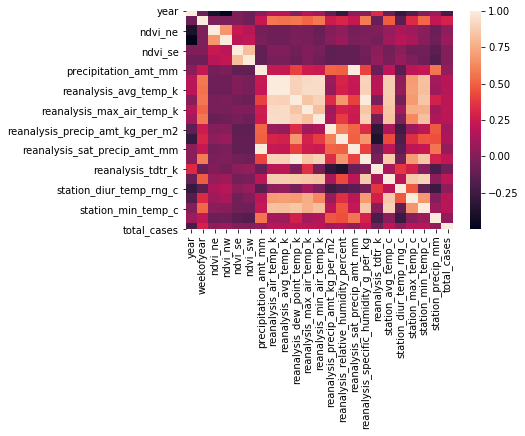

In [1786]:
#Correlation heatmap for SJ

sns.heatmap(df_train_sj.corr())

In [1787]:
#Strong correlations between variables expressed in a dictionary (SJ)

sj_corr_dict = {}
for col in df_train_sj.corr().columns:
    sj_corr_dict[col] = [(idx, df_train_sj.corr()[col][idx]) for idx in df_train_sj.corr().columns if idx != col and abs(df_train_sj.corr()[col][idx]) >= .6]
    
sj_corr_dict

C:\Users\ellio\Anaconda3\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


{'year': [],
 'weekofyear': [],
 'ndvi_ne': [('ndvi_nw', 0.6730370912362169)],
 'ndvi_nw': [('ndvi_ne', 0.6730370912362169)],
 'ndvi_se': [('ndvi_sw', 0.8213540520802144)],
 'ndvi_sw': [('ndvi_se', 0.8213540520802144)],
 'precipitation_amt_mm': [('reanalysis_sat_precip_amt_mm', 1.0)],
 'reanalysis_air_temp_k': [('reanalysis_avg_temp_k', 0.9974952432829403),
  ('reanalysis_dew_point_temp_k', 0.9032871230982901),
  ('reanalysis_max_air_temp_k', 0.935088959026492),
  ('reanalysis_min_air_temp_k', 0.9422536353865085),
  ('reanalysis_specific_humidity_g_per_kg', 0.9048189392495243),
  ('station_avg_temp_c', 0.880930948014158),
  ('station_max_temp_c', 0.697948599077625),
  ('station_min_temp_c', 0.8328632546055222)],
 'reanalysis_avg_temp_k': [('reanalysis_air_temp_k', 0.9974952432829403),
  ('reanalysis_dew_point_temp_k', 0.895122758424718),
  ('reanalysis_max_air_temp_k', 0.9389516028711338),
  ('reanalysis_min_air_temp_k', 0.9391201588703382),
  ('reanalysis_specific_humidity_g_per_kg', 

We see that strong positive correlations exist between `ndvi_ne` and `ndvi_nw` as well as `ndvi_se` and `ndvi_sw`. Interestingly, the correlations are weaker between north and south pixels. A perfect positive linear relationship exists between `precipitation_amt_mm` and `reanalysis_sat_precip_amt_mm`. Therefore, we should eliminate one of these variables when we begin modeling. We also see strong positive correlations between the temperature-related variables (`reanalysis_avg_temp_k`, `reanalysis_max_air_temp_k`, `reanalysis_air_temp_k`, `reanalysis_dew_point_temp_k`, `reanalysis_min_air_temp_k`, `reanalysis_specific_humidity_g_per_kg`, `station_avg_temp_c`, `station_max_temp_c`, `station_min_temp_c`). However, `reanalysis_specific_humidity_g_per_kg` and `reanalysis_relative_humidity_percent` do not correlate as strongly (~0.67) as the temperature-related variables and even `reanalysis_specific_humidity_g_per_kg` with the temperature-related variables.

#### IQ Variable Correlations

In [1788]:
#Correlation of variables with total_cases in IQ

df_train_iq.corr()['total_cases'].sort_values()

reanalysis_tdtr_k                       -0.134425
station_diur_temp_rng_c                 -0.058230
reanalysis_max_air_temp_k               -0.056474
ndvi_se                                 -0.041067
weekofyear                              -0.011850
ndvi_nw                                 -0.009586
ndvi_ne                                  0.020215
ndvi_sw                                  0.032999
station_precip_mm                        0.042976
station_max_temp_c                       0.075279
reanalysis_avg_temp_k                    0.079872
precipitation_amt_mm                     0.090171
reanalysis_sat_precip_amt_mm             0.090171
reanalysis_air_temp_k                    0.097098
reanalysis_precip_amt_kg_per_m2          0.101171
station_avg_temp_c                       0.113070
reanalysis_relative_humidity_percent     0.130083
year                                     0.179451
station_min_temp_c                       0.211702
reanalysis_min_air_temp_k                0.214514


None of the variables strongly correlate with `total_cases`, but 6 variables have a negative linear relationship with the response for IQ as opposed to 3 in SJ. Also, contrary to in SJ, `weekofyear` is a very weak predictor in IQ but `year` remains one of the most indicative variables. Temperature and humidity-related variables somewhat strongly correlate with `total_cases` whereas precipitation-related and NDVI variables are weak correlators. Given that precipitation-related variables have a weak relationship for both SJ and IQ, it is unlikely due to the distribution of the variable but rather its relationship to the response. Variables measuring minimum temperature have greater relationships to the response than do those measuring max temperature for IQ whereas the opposite was true for SJ. 

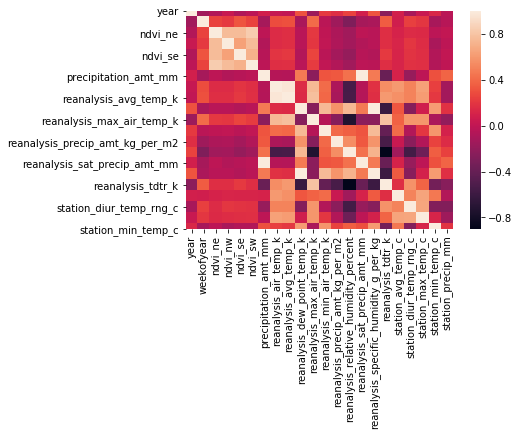

In [1789]:
#Correlation heatmap for IQ

sns.heatmap(X_train_iq.corr())

In [1790]:
#Strong correlations between variables expressed in a dictionary (IQ)

iq_corr_dict = {}
for col in df_train_iq.corr().columns:
    iq_corr_dict[col] = [(idx, df_train_iq.corr()[col][idx]) for idx in df_train_iq.corr().columns if idx != col and abs(df_train_iq.corr()[col][idx]) >= .6]
    
iq_corr_dict

{'year': [],
 'weekofyear': [],
 'ndvi_ne': [('ndvi_nw', 0.76440738151147),
  ('ndvi_se', 0.7677446793490766),
  ('ndvi_sw', 0.8427841733019975)],
 'ndvi_nw': [('ndvi_ne', 0.76440738151147),
  ('ndvi_se', 0.6441940048009587),
  ('ndvi_sw', 0.7648292811518687)],
 'ndvi_se': [('ndvi_ne', 0.7677446793490766),
  ('ndvi_nw', 0.6441940048009587),
  ('ndvi_sw', 0.7145765462101681)],
 'ndvi_sw': [('ndvi_ne', 0.8427841733019975),
  ('ndvi_nw', 0.7648292811518687),
  ('ndvi_se', 0.7145765462101681)],
 'precipitation_amt_mm': [('reanalysis_sat_precip_amt_mm', 1.0)],
 'reanalysis_air_temp_k': [('reanalysis_avg_temp_k', 0.9733190751577622),
  ('reanalysis_max_air_temp_k', 0.7523560282346532),
  ('station_avg_temp_c', 0.6026173636562316),
  ('station_max_temp_c', 0.6412300334286304)],
 'reanalysis_avg_temp_k': [('reanalysis_air_temp_k', 0.9733190751577622),
  ('reanalysis_max_air_temp_k', 0.783955457376869),
  ('reanalysis_tdtr_k', 0.6016292346447026),
  ('station_max_temp_c', 0.6180173638420717)],


We see that strong positive correlations exist between all NDVI variables in IQ. A perfect positive linear relationship exists between `precipitation_amt_mm` and `reanalysis_sat_precip_amt_mm` for IQ as it did for SJ. Therefore, we should eliminate one of these variables when we begin modeling. 

We also see strong positive and negative correlations between the temperature-related variables (`reanalysis_avg_temp_k`, `reanalysis_max_air_temp_k`, `reanalysis_air_temp_k`, `reanalysis_min_air_temp_k`, `reanalysis_relative_humidity_percent`, `reanalysis_tdtr_k`) and between temperature and temperature-related and humidity-related variables (`reanalysis_dew_point_temp_k`, `reanalysis_specific_humidity_g_per_kg`, `reanalysis_min_air_temp_k`). 

Unlike in SJ, the station and reanalysis temperature variables do not correlate as strongly. As a result, we may be able to gain extra information from using both in IQ. In general, the variables exhibit less collinearity for IQ than SJ. 

#### Total Cases Exploration

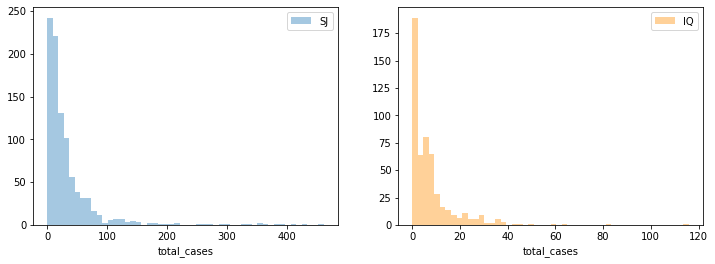

In [1791]:
#Distribution of total cases by city

fig = plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
sns.distplot(a=y_train_sj['total_cases'], kde = False, label = 'SJ')
plt.legend()
fig.add_subplot(1,2,2)
sns.distplot(a=y_train_iq['total_cases'], kde = False, label = 'IQ', color = 'darkorange')
plt.legend()

The total cases in each city has a high concentration of low-valued numbers, is non-negative, contains a long right tail, and is discrete, count data. This indicates that the target, `total_cases`, follows a Negative Binomial or Poisson distribution (if errors' mean = variance). 

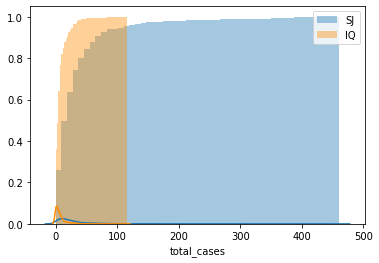

In [1792]:
#Cumulative density of occurrences of total cases

kwargs = {'cumulative': True}

sns.distplot(y_train_sj['total_cases'], hist_kws=kwargs, label = 'SJ')
sns.distplot(y_train_iq['total_cases'], hist_kws=kwargs, label = 'IQ', color = 'darkorange')
plt.legend()

In [1793]:
#Total cases statistics

percent_zero_iq = (y_train_labels_iq == 0).sum() / y_train_iq.shape[0]
percent_zero_sj = (y_train_labels_sj == 0).sum() / y_train_sj.shape[0]
percent_five_or_lower_iq = (y_train_labels_iq <= 5).sum() / y_train_iq.shape[0]
percent_five_or_lower_sj = (y_train_labels_sj <= 5).sum() / y_train_sj.shape[0]

percent_sj_above_max_iq = (y_train_labels_sj > y_train_labels_iq.max()).sum() / y_train_sj.shape[0]

print('Median cases IQ: {:.1f}. Mean cases IQ: {:.1f}. Variance of cases IQ: {:.1f}'.format(y_train_iq['total_cases'].median(), y_train_iq['total_cases'].mean(), y_train_iq['total_cases'].var()))
print('Median cases SJ: {:.1f}. Mean cases SJ: {:.1f}. Variance of cases SJ: {:.1f}'.format(y_train_sj['total_cases'].median(), y_train_sj['total_cases'].mean(), y_train_sj['total_cases'].var()))
print('{:.2%} of weeks recorded 0 cases in IQ and {:.2%} of weeks recorded 0 cases in SJ'.format(percent_zero_iq, percent_zero_sj))
print('{:.2%} of weeks recorded 5 cases or fewer in IQ and {:.2%} of weeks recorded 5 cases or fewer in SJ'.format(percent_five_or_lower_iq, percent_five_or_lower_sj))
print('{:.2%} of weeks in SJ had more than {} cases, the max cases ever recorded in IQ'.format(percent_sj_above_max_iq, y_train_iq['total_cases'].max()))

Median cases IQ: 5.0. Mean cases IQ: 7.6. Variance of cases IQ: 115.9
Median cases SJ: 19.0. Mean cases SJ: 34.2. Variance of cases SJ: 2640.0
18.46% of weeks recorded 0 cases in IQ and 0.43% of weeks recorded 0 cases in SJ
57.12% of weeks recorded 5 cases or fewer in IQ and 13.57% of weeks recorded 5 cases or fewer in SJ
4.59% of weeks in SJ had more than 116 cases, the max cases ever recorded in IQ


Not only does the distribution of `total_cases` for SJ have a longer tail than it does for IQ, but it is less concentrated around lower `total_cases` values and has a much larger variance. 

Text(0.5, 1.0, 'IQ Total Cases by Month')

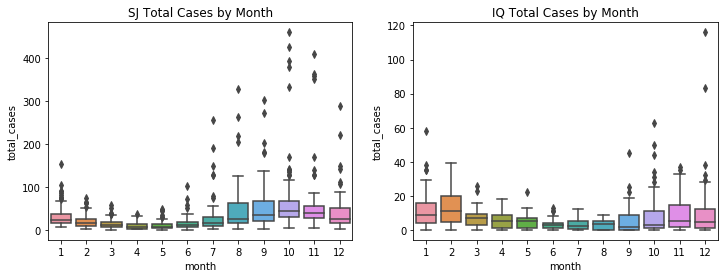

In [1794]:
#Boxplots of total_cases in SJ and IQ by month

fig = plt.figure(figsize=(12,4))

#SJ
sj_week_start_date = pd.to_datetime(y_train_sj.week_start_date)
y_train_sj['month'] = sj_week_start_date.map(lambda x: x.month)

fig.add_subplot(1,2,1)
sns.boxplot(x = y_train_sj.month, y = y_train_labels_sj)
plt.title('SJ Total Cases by Month')

#IQ
iq_week_start_date = pd.to_datetime(y_train_iq.week_start_date)
y_train_iq['month'] = iq_week_start_date.map(lambda x: x.month)

fig.add_subplot(1,2,2)
sns.boxplot(x = y_train_iq.month, y = y_train_labels_iq)
plt.title('IQ Total Cases by Month')

Both SJ and IQ have months with lower and less variable `total_cases` and months with higher average `total_cases` that contain large outliers. It appears that, in both cities, half of the months belong to one group and half to the other. Also, these months are consecutive, indicating that there are two seasons of dengue fever infection and that weather features are likely a major contributor to the spread. In SJ, the low spread and low variability season lasts from February through June and the higher spread, high variability season goes from July through January. In IQ, March through August are in the former and September through February are in the latter. 

Text(0.5, 1.0, 'IQ Total Cases by Year')

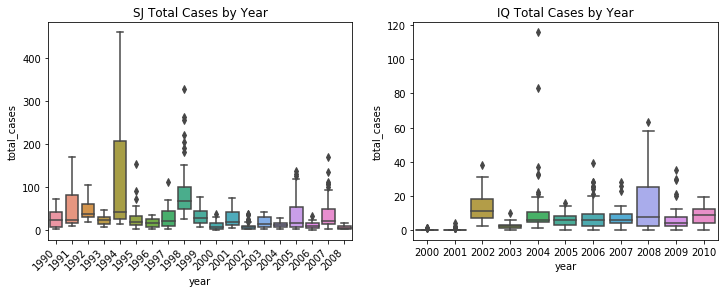

In [1795]:
#Boxplots of total_cases in SJ and IQ by year

fig = plt.figure(figsize=(12,4))

#SJ
fig.add_subplot(1,2,1)
plot = sns.boxplot(x = y_train_sj.year, y = y_train_labels_sj)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('SJ Total Cases by Year')

#IQ
fig.add_subplot(1,2,2)
sns.boxplot(x = y_train_iq.year, y = y_train_labels_iq)
plt.title('IQ Total Cases by Year')

The boxplots of `total_cases` by year display a couple of important aspects of the data. First, there is no discernible pattern between years. This observation falls inline with our understanding of dengue fever, as an infectious disease would have no reasonable ties to year. Second, in SJ especially, outliers are not distributed among the years uniformly. Outliers are bunched in certain years. This also makes sense as dengue fever is contagious (with mosquitos being the carriers of the virus) and so the spread is exacerbated by not only weather conditions, but also by the number of carriers. These factors will be important in feature engineering to improve the prediction power of the models.

# Preliminary Feature Engineering, Preprocessing, and Modeling

### Preprocessing and Feature Engineering

In [1796]:
#Adding month and day features from week_start_date

sj_week_start_date = pd.to_datetime(X_train_sj.week_start_date)
X_train_sj['day'] = sj_week_start_date.map(lambda x: x.day)
X_train_sj['month'] = sj_week_start_date.map(lambda x: x.month)

iq_week_start_date = pd.to_datetime(X_train_iq.week_start_date)
X_train_iq['day'] = iq_week_start_date.map(lambda x: x.day)
X_train_iq['month'] = iq_week_start_date.map(lambda x: x.month)

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [1797]:
#Returning years that contain week 53

def years_with_53_weeks(df):
    return list(df.loc[df.weekofyear == 53].year.unique())

sj_train_years_with_53 = years_with_53_weeks(X_train_sj)
iq_train_years_with_53 = years_with_53_weeks(X_train_iq)

print('Years {} contain week 53 in SJ. Years {} contain week 53 in IQ'.format(sj_train_years_with_53, iq_train_years_with_53))

Years [1993, 1999, 2005] contain week 53 in SJ. Years [2005, 2010] contain week 53 in IQ


In [1798]:
#Creating function that changes week 53 to week 1 and adds 1 to all other weekofyear in the years this occurs

def weekofyear_function(row, years_with_53):
    #adds 1 to all other weeks during a year where week 53 is present
    if ((row.year in years_with_53) and ((row.day!=1) or (row.month!=1))):
        row.weekofyear = row.weekofyear+1
    #changes week 53 to week 1
    elif (row.year in years_with_53) and (row.weekofyear == 53):
        row.weekofyear = 1
    return row

In [1799]:
#Implementing weekofyear_function on X_train_sj and X_train_iq data sets

X_train_sj_feat_eng = X_train_sj.apply(lambda x: weekofyear_function(x, sj_train_years_with_53), axis = 'columns')
X_train_iq_feat_eng = X_train_iq.apply(lambda x: weekofyear_function(x, iq_train_years_with_53), axis = 'columns')

In [1800]:
X_train_iq_feat_eng.loc[X_train_iq_feat_eng.year == 2005]
X_train_iq_feat_eng.select_dtypes(include=['float64', 'int64']).head(1)

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  ndvi_sw  \
936  2000          26  0.192886  0.132257  0.340886   0.2472   

     precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
936                 25.41                 296.74                 298.45   

     reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
936                   295.184286                      307.3   

     reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
936                      293.1                            43.19   

     reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
936                             92.418571                         25.41   

     reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
936                              16.651429           8.928571   

     station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
936                26.4                   10.775                32.5   

     station_min_temp_c  station_precip_mm  day  month  
936                20.7                3.0    1      7

In [1954]:
#Preprocessing pipeline

knn_imputer = KNNImputer(weights = 'distance')

#only keep columns with numeric data
X_sj = X_train_sj_feat_eng.select_dtypes(include=['float64', 'int64'])
X_iq = X_train_iq_feat_eng.select_dtypes(include=['float64', 'int64'])

#only step in pipeline is to impute missing values based on "nearest" data points
preprocessor_pipeline = Pipeline(steps = [
    ('impute', knn_imputer)])

preprocessor_pipeline.fit_transform(X_sj)[0]
preprocessor_pipeline.fit_transform(X_iq)[0]

array([2.00000000e+03, 2.60000000e+01, 1.92885700e-01, 1.32257100e-01,
       3.40885700e-01, 2.47200000e-01, 2.54100000e+01, 2.96740000e+02,
       2.98450000e+02, 2.95184286e+02, 3.07300000e+02, 2.93100000e+02,
       4.31900000e+01, 9.24185714e+01, 2.54100000e+01, 1.66514286e+01,
       8.92857143e+00, 2.64000000e+01, 1.07750000e+01, 3.25000000e+01,
       2.07000000e+01, 3.00000000e+00, 1.00000000e+00, 7.00000000e+00])

### Modeling

#### Baseline Model

In [2266]:
#SJ baseline model

from sklearn.dummy import DummyRegressor

#TimeSeriesSplit is a method of cross validation that prevents data leakage that can arise when using k-fold cv on time series data
tscv = TimeSeriesSplit(n_splits=2)

dummy_model = DummyRegressor(strategy='mean')

sj_dummy_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  dummy_model)
])

cv_dummy_sj = cross_val_score(sj_dummy_pipeline, X_sj, y_train_labels_sj, scoring = 'neg_mean_absolute_error', cv=tscv)
print('SJ: MAE for {} is {:.3f}'.format(dummy_model, abs(cv_dummy_sj.mean())))

SJ: MAE for DummyRegressor() is 31.387


In [2207]:
tscv2 = TimeSeriesSplit(n_splits=2)

iq_dummy_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  dummy_model)
])

cv_dummy_iq = cross_val_score(iq_dummy_pipeline, X_iq, y_train_labels_iq, scoring = 'neg_mean_absolute_error', cv=tscv2)
print('IQ: MAE for {} is {:.3f}'.format(dummy_model, abs(cv_dummy_iq.mean())))

IQ: MAE for DummyRegressor() is 6.405


The Dummy Regressor serves as a baseline model as we test different models to find the one best for the dataset. It is invariant to preprocessing as it solely relies on the labels, which have not been transformed or changed in any way.

#### Poisson Regression

In [2270]:
#Poisson regression (SJ)

poisson_parameters = {'model__alpha': [0, 0.01, 0.1, 0.5, 1, 2, 10, 100]}
model = PoissonRegressor()

#each model will use the full_pipeline, which includes the preliminary preprocessing
full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

#running gridsearch cross validation on the Poisson Regressor to find optimal alpha
gscv_poisson_sj = GridSearchCV(estimator=full_pipeline, param_grid=poisson_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_poisson_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_poisson_sj.best_score_)
print(gscv_poisson_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_poisson_sj.cv_results_)

C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Best parameter (CV score=-27.241):
{'model__alpha': 0.5}
all results:


C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.068045      0.009455         0.015952        0.000297   
1       0.039190      0.004945         0.017844        0.001155   
2       0.062537      0.005527         0.021268        0.003650   
3       0.068482      0.005615         0.020096        0.004106   
4       0.068591      0.000639         0.025545        0.006450   
5       0.075505      0.013116         0.024505        0.007430   
6       0.065043      0.003028         0.022598        0.001386   
7       0.065198      0.010798         0.026007        0.000070   

  param_model__alpha                  params  split0_test_score  \
0                  0     {'model__alpha': 0}         -36.319501   
1               0.01  {'model__alpha': 0.01}         -35.171004   
2                0.1   {'model__alpha': 0.1}         -36.209287   
3                0.5   {'model__alpha': 0.5}         -33.501721   
4                  1     {'model__alpha': 1}         -35.043721   
5                  2     {'model__alpha': 2}         -34.328234   
6                 10    {'model__alpha': 10}         -34.933759   
7                100   {'model__alpha': 100}         -34.253820   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0         -21.276716       -28.798109        7.521393                6  
1         -19.444355       -27.307680        7.863325                2  
2         -20.158126       -28.183707        8.025581                3  
3         -20.979561       -27.240641        6.261080                1  
4         -22.633313       -28.838517        6.205204                7  
5         -22.563454       -28.445844        5.882390                4  
6         -21.983044       -28.458402        6.475358                5  
7         -25.185808       -29.719814        4.534006                8

In [2271]:
#Poisson regression with lowest mean absolute error (SJ)

pd.DataFrame(gscv_poisson_sj.cv_results_).loc[pd.DataFrame(gscv_poisson_sj.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.068482      0.005615         0.020096        0.004106   

  param_model__alpha                 params  split0_test_score  \
3                0.5  {'model__alpha': 0.5}         -33.501721   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
3         -20.979561       -27.240641         6.26108                1

In [2272]:
#Function that graphs the predictions made on the validation folds during GridSearchCV

def graph_gscv_preds(gscv, pipeline, model, X, y, model_name):
    val_preds = []
    val_indeces = []
    y_labels = y.total_cases
    
    if X_sj.equals(X):
        ts = tscv
    else:
        ts = tscv2
    
    for train_index, val_index in ts.split(X):
        pipeline.fit(X.iloc[train_index], y_labels.iloc[train_index])
        val_preds += list(pipeline.predict(X.iloc[val_index]))
        val_indeces += list(val_index)
            
    pipeline.set_params(**gscv.best_params_)

    if X.equals(X_sj):
        city = 'SJ'
        gscv_preds = pd.DataFrame(val_preds, index = val_indeces, columns = ['gscv_{}_predictions'.format(model_name)])
    
    else:
        city = 'IQ'
        starting_index = y.index.min()
        val_indeces_new = [idx + starting_index for idx in val_indeces]
        gscv_preds = pd.DataFrame(val_preds, index = val_indeces_new, columns = ['gscv_{}_predictions'.format(model_name)])

    gscv_preds = y.join(gscv_preds, how = 'left')
    gscv_preds[['week_start_date','total_cases', 'gscv_{}_predictions'.format(model_name)]].set_index('week_start_date').plot()
    plt.title('{} Total Cases vs. Predicted Cases using {}'.format(city, model))
    return gscv_preds

C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


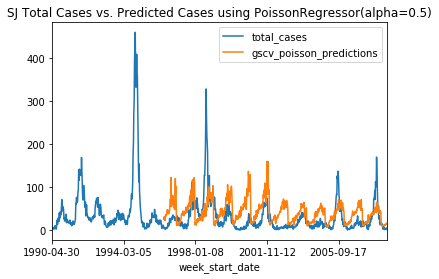

In [2273]:
#SJ: graph best GSCV Poisson model

gscv_poisson_preds_sj = graph_gscv_preds(gscv_poisson_sj, full_pipeline, model, X_sj, y_train_sj, 'poisson')

C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


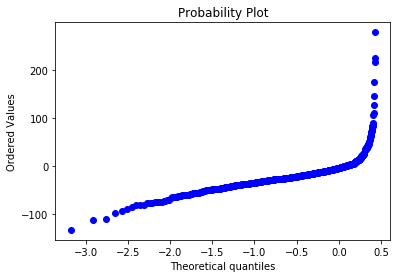

In [2274]:
#qq-plot for Poisson Regression (SJ)

import pylab 
import scipy.stats as stats

residuals_sj = gscv_poisson_preds_sj.total_cases - gscv_poisson_preds_sj.gscv_poisson_predictions
gscv_poisson_preds_sj['residuals'] = residuals_sj

stats.probplot(residuals_sj, dist="norm", plot=pylab)
pylab.show()

In [2213]:
#Poisson regression (IQ)

gscv_poisson_iq = GridSearchCV(estimator=full_pipeline, param_grid=poisson_parameters, scoring = 'neg_mean_absolute_error', cv=tscv2)
gscv_poisson_iq.fit(X_iq, y_train_labels_iq)

print("Best parameter (CV score=%0.3f):" % gscv_poisson_iq.best_score_)
print(gscv_poisson_iq.best_params_)
print("all results:")
pd.DataFrame(gscv_poisson_iq.cv_results_)

C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Best parameter (CV score=-6.484):
{'model__alpha': 2}
all results:


C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.053865      0.007366         0.016733        0.000796   
1       0.042576      0.007297         0.014810        0.000142   
2       0.033443      0.006756         0.012695        0.003941   
3       0.037226      0.003882         0.021049        0.003545   
4       0.041172      0.001084         0.012679        0.003961   
5       0.036731      0.011786         0.020463        0.001191   
6       0.029710      0.004482         0.015326        0.001326   
7       0.043755      0.010448         0.017941        0.002727   

  param_model__alpha                  params  split0_test_score  \
0                  0     {'model__alpha': 0}          -5.978864   
1               0.01  {'model__alpha': 0.01}          -6.000421   
2                0.1   {'model__alpha': 0.1}          -5.928315   
3                0.5   {'model__alpha': 0.5}          -5.993436   
4                  1     {'model__alpha': 1}          -5.960912   
5                  2     {'model__alpha': 2}          -5.959289   
6                 10    {'model__alpha': 10}          -5.851368   
7                100   {'model__alpha': 100}          -5.777637   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0          -7.088542        -6.533703        0.554839                5  
1          -7.666069        -6.833245        0.832824                8  
2          -7.095070        -6.511693        0.583377                2  
3          -7.564186        -6.778811        0.785375                7  
4          -7.096027        -6.528470        0.567557                4  
5          -7.009425        -6.484357        0.525068                1  
6          -7.186394        -6.518881        0.667513                3  
7          -7.479369        -6.628503        0.850866                6

In [2214]:
#Poisson regression with lowest mean absolute error (IQ)

pd.DataFrame(gscv_poisson_iq.cv_results_).loc[pd.DataFrame(gscv_poisson_iq.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.036731      0.011786         0.020463        0.001191   

  param_model__alpha               params  split0_test_score  \
5                  2  {'model__alpha': 2}          -5.959289   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
5          -7.009425        -6.484357        0.525068                1

C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


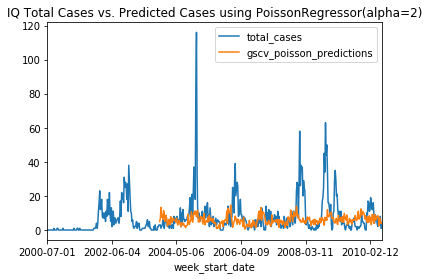

In [2215]:
#IQ: graph best GSCV Poisson model

gscv_poisson_preds_iq = graph_gscv_preds(gscv_poisson_iq, full_pipeline, model, X_iq, y_train_iq, 'poisson')

Similary to the Poisson regressor fit for the SJ dataset, this model vastly underestimates peak periods. The constant prediction is the mean target of the training fold.  

C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ellio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


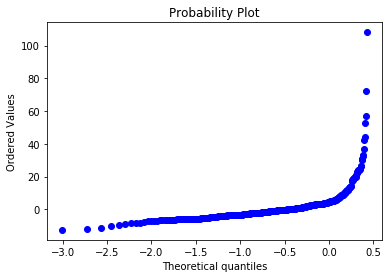

In [2216]:
#qq-plot for Poisson Regression (IQ)

residuals_iq = gscv_poisson_preds_iq.total_cases - gscv_poisson_preds_iq.gscv_poisson_predictions
gscv_poisson_preds_iq['residuals'] = residuals_iq

stats.probplot(residuals_iq, dist="norm", plot=pylab)
pylab.show()

In summary, a Poisson regression model does not fit the data well (non-normal errors), likely because the variance of `total_cases` is much greater than its mean. While the model does seem to capture some of the cyclical nature of the data, it vastly underestimates the peaks.

#### Random Forest Regressor

In [2275]:
#RF Regressor (SJ)

rf_parameters = {'model__n_estimators': [2, 5, 10, 20], 'model__max_depth': [5, 10, 15, 20, None], 'model__min_samples_leaf': [1, 2, 5, 10], 'model__max_features': ['auto', 'sqrt', .333]}
model = RandomForestRegressor(criterion = 'mae', random_state = 0)

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_rf_sj = GridSearchCV(estimator=full_pipeline, param_grid=rf_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_rf_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_rf_sj.best_score_)
print(gscv_rf_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_rf_sj.cv_results_)

Best parameter (CV score=-20.619):
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__n_estimators': 10}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.111391      0.047801         0.021823    1.267672e-03   
1         0.273865      0.108881         0.026103    5.876899e-03   
2         0.489467      0.225430         0.026539    5.441070e-03   
3         0.907992      0.429467         0.030980    1.608968e-03   
4         0.122511      0.041508         0.023985    7.994890e-03   
5         0.260630      0.119248         0.028960    3.002405e-03   
6         0.474923      0.210430         0.023985    3.576279e-07   
7         0.897443      0.423076         0.027132    3.146768e-03   
8         0.135347      0.053211         0.033506    6.675243e-03   
9         0.246565      0.088065         0.022435    3.558636e-03   
10        0.440545      0.189978         0.027983    3.997564e-03   
11        0.769683      0.336533         0.024602    2.231479e-03   
12        0.110063      0.042923         0.019059    1.998663e-03   
13        0.228298      0.114984         0.021762    1.553535e-03   
14        0.407785      0.215603         0.025713    1.694560e-03   
15        0.755487      0.347270         0.027448    3.196836e-03   
16        0.042096      0.006835         0.021941    7.066369e-03   
17        0.079538      0.023223         0.026757    3.334522e-03   
18        0.130633      0.035478         0.025986    1.823187e-03   
19        0.246576      0.093050         0.026227    1.129389e-03   
20        0.052292      0.014668         0.028020    2.987504e-03   
21        0.088439      0.017556         0.027133    4.207969e-03   
22        0.137073      0.051026         0.030688    1.291752e-03   
23        0.228199      0.083539         0.025573    4.638433e-03   
24        0.053305      0.003991         0.025216    1.986146e-03   
25        0.072421      0.024044         0.022079    2.371073e-04   
26        0.138376      0.052249         0.028276    1.736403e-03   
27        0.226509      0.113258         0.028264    2.202988e-04   
28        0.052581      0.009920         0.025389    2.701044e-03   
29        0.078393      0.028401         0.021850    2.135873e-03   
30        0.111525      0.041167         0.030148    8.457899e-04   
31        0.196697      0.093349         0.026927    2.941847e-03   
32        0.063957      0.015989         0.023985    5.960464e-07   
33        0.101019      0.039143         0.025265    1.280546e-03   
34        0.182172      0.072092         0.023985    3.576279e-07   
35        0.337168      0.142272         0.029101    2.879500e-03   
36        0.053791      0.008666         0.020065    6.890297e-04   
37        0.101482      0.019839         0.024891    2.117276e-03   
38        0.177310      0.069204         0.027083    3.072619e-03   
39        0.289855      0.087634         0.020539    3.873110e-04   
40        0.069089      0.026796         0.027990    4.006386e-03   
41        0.108485      0.036292         0.019987    3.997684e-03   
42        0.196599      0.070338         0.029044    2.401233e-03   
43        0.338406      0.146081         0.043350    1.510954e-02   
44        0.083543      0.011592         0.034239    1.547337e-03   
45        0.094088      0.032520         0.019995    1.424909e-03   
46        0.145282      0.070838         0.024073    2.288818e-05   
47        0.263933      0.114729         0.030666    8.621216e-03   
48        0.166268      0.056812         0.024739    1.640797e-03   
49        0.342408      0.160601         0.025028    1.130223e-03   
50        0.733334      0.336303         0.032089    6.054521e-03   
51        1.180083      0.582223         0.029518    2.417684e-03   
52        0.153694      0.072590         0.026408    1.331806e-03   
53        0.265213      0.089993         0.027459    3.474236e-03   
54        0.648263      0.288244         0.025401    1.450658e-03   
55        1.182109      0.571401         0.026146    1.936436e-03   
56        0.126965      0.051825         0.027640    3.655553e-03   
57 

In [2276]:
#RF regression with lowest mean absolute error (SJ)

pd.DataFrame(gscv_rf_sj.cv_results_).loc[pd.DataFrame(gscv_rf_sj.cv_results_).rank_test_score == 1]
# [['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
126       0.120141      0.049990         0.025005        0.001034   
174       0.132829      0.069664         0.025087        0.001101   
222       0.133572      0.051749         0.024907        0.002340   

    param_model__max_depth param_model__max_features  \
126                     15                      sqrt   
174                     20                      sqrt   
222                   None                      sqrt   

    param_model__min_samples_leaf param_model__n_estimators  \
126                            10                        10   
174                            10                        10   
222                            10                        10   

                                                                                                                  params  \
126    {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__n_estimators': 10}   
174    {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__n_estimators': 10}   
222  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__n_estimators': 10}   

     split0_test_score  split1_test_score  mean_test_score  std_test_score  \
126         -23.335417         -17.901763        -20.61859        2.716827   
174         -23.335417         -17.901763        -20.61859        2.716827   
222         -23.335417         -17.901763        -20.61859        2.716827   

     rank_test_score  
126                1  
174                1  
222                1

The best random forest fit using GridSearch cross validation on the SJ data achieved a much lower mean absolute error than the Poisson regressor. This may be due to the non-parametric nature of random forests as they do not have to conform to an underlying distribution. 

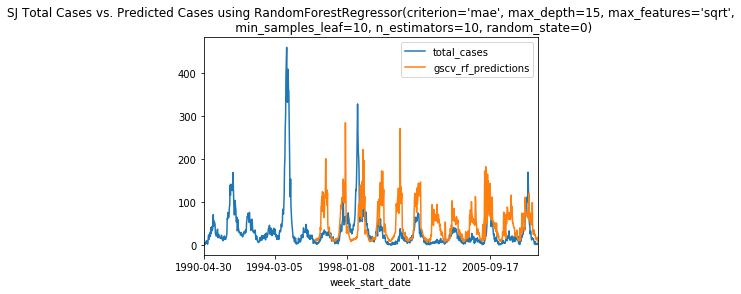

In [2277]:
#SJ: graph best GSCV RF model

gscv_rf_preds_sj = graph_gscv_preds(gscv_rf_sj, full_pipeline, model, X_sj, y_train_sj, 'rf')

The best random forest fit on SJ is similar to the Poisson regressor in its cyclical nature (although the random forest is much more subdued) and its underestimation of peak periods. This indicates that advanced feature engineering may be needed to capture these peaks.

In [2220]:
#RF Regressor (IQ)

gscv_rf_iq = GridSearchCV(estimator=full_pipeline, param_grid=rf_parameters, scoring = 'neg_mean_absolute_error', cv=tscv2)
gscv_rf_iq.fit(X_iq, y_train_labels_iq)

print("Best parameter (CV score=%0.3f):" % gscv_rf_iq.best_score_)
print(gscv_rf_iq.best_params_)
print("all results:")
pd.DataFrame(gscv_rf_iq.cv_results_)

Best parameter (CV score=-6.304):
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 20}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.077839      0.022212         0.029985    1.466393e-03   
1         0.141608      0.059286         0.023657    5.928755e-03   
2         0.231520      0.077132         0.027969    3.259420e-03   
3         0.416432      0.167895         0.020712    2.234221e-03   
4         0.060152      0.027867         0.023475    3.012657e-03   
5         0.112480      0.050608         0.023147    2.127767e-03   
6         0.210465      0.088056         0.023906    2.639532e-03   
7         0.429133      0.165236         0.029248    6.675720e-03   
8         0.065090      0.017909         0.025096    6.645918e-03   
9         0.106169      0.028632         0.017719    2.491474e-05   
10        0.179371      0.067986         0.024027    4.269361e-03   
11        0.348196      0.150503         0.021674    5.002141e-03   
12        0.058613      0.020121         0.024344    3.170490e-03   
13        0.098727      0.038389         0.017471    2.031446e-03   
14        0.156447      0.061112         0.022581    1.347423e-03   
15        0.288154      0.100810         0.018700    3.708601e-04   
16        0.039938      0.015992         0.018715    1.075506e-03   
17        0.049345      0.009786         0.022929    2.056241e-03   
18        0.072586      0.022259         0.020121    1.215339e-03   
19        0.120877      0.032773         0.019787    7.297993e-04   
20        0.034658      0.001922         0.025556    6.836653e-04   
21        0.048876      0.016765         0.016680    9.859800e-04   
22        0.067475      0.012673         0.020670    7.107258e-04   
23        0.121640      0.038358         0.020418    1.278400e-03   
24        0.035826      0.010703         0.021557    3.888607e-03   
25        0.045268      0.006900         0.018677    2.267241e-03   
26        0.065550      0.023532         0.022206    2.348185e-03   
27        0.110099      0.039705         0.025087    2.264619e-03   
28        0.026918      0.006930         0.020988    2.779007e-03   
29        0.037830      0.005741         0.020369    4.585624e-03   
30        0.056494      0.019001         0.023915    4.287839e-03   
31        0.107739      0.025402         0.026166    1.714230e-03   
32        0.036665      0.012206         0.021056    2.399683e-03   
33        0.054984      0.013649         0.022971    7.872581e-04   
34        0.087745      0.026255         0.019024    1.482964e-04   
35        0.149693      0.041279         0.023515    5.920649e-03   
36        0.032965      0.015999         0.022921    4.373670e-03   
37        0.055984      0.020792         0.021762    5.756617e-04   
38        0.080900      0.027821         0.024579    4.947186e-05   
39        0.154856      0.068316         0.024289    2.321005e-04   
40        0.035099      0.009264         0.020880    4.143476e-03   
41        0.057925      0.027303         0.027314    9.428263e-04   
42        0.078977      0.017534         0.020267    2.755165e-03   
43        0.140010      0.046410         0.015679    3.136992e-03   
44        0.029851      0.012342         0.021560    3.151774e-03   
45        0.048423      0.016700         0.022333    3.930330e-04   
46        0.069815      0.019407         0.020771    2.826452e-03   
47        0.112426      0.043373         0.024985    2.029419e-03   
48        0.074834      0.024945         0.019948    4.276633e-03   
49        0.160463      0.060457         0.023357    2.311468e-04   
50        0.335994      0.125940         0.024079    5.709767e-03   
51        0.603388      0.242170         0.030239    5.529642e-03   
52        0.075255      0.037075         0.027165    9.511113e-03   
53        0.123351      0.060317         0.017460    2.688169e-04   
54        0.236713      0.106670         0.020079    1.281857e-03   
55        0.476936      0.194880         0.024617    5.028963e-03   
56        0.075324      0.034132         0.024063    1.175761e-03   
57 

In [2221]:
#RF regression with lowest mean absolute error (IQ)

pd.DataFrame(gscv_rf_iq.cv_results_).loc[pd.DataFrame(gscv_rf_iq.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
123       0.138991      0.046887         0.020147        0.002791   
171       0.120281      0.040218         0.029399        0.000387   
219       0.124118      0.042704         0.023311        0.000117   

    param_model__max_depth param_model__max_features  \
123                     15                      sqrt   
171                     20                      sqrt   
219                   None                      sqrt   

    param_model__min_samples_leaf param_model__n_estimators  \
123                             5                        20   
171                             5                        20   
219                             5                        20   

                                                                                                                 params  \
123    {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 20}   
171    {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 20}   
219  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 20}   

     split0_test_score  split1_test_score  mean_test_score  std_test_score  \
123          -5.651301           -6.95578         -6.30354         0.65224   
171          -5.651301           -6.95578         -6.30354         0.65224   
219          -5.651301           -6.95578         -6.30354         0.65224   

     rank_test_score  
123                1  
171                1  
219                1

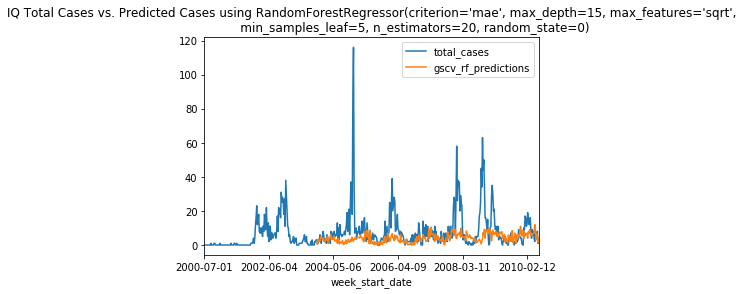

In [2222]:
#IQ: graph best GSCV RF model

gscv_rf_preds_iq = graph_gscv_preds(gscv_rf_iq, full_pipeline, model, X_iq, y_train_iq, 'rf')

The constant prediction during the period from 2002 to mid-2006 is likely due to the smaller training set sizes as a result of cross validation and the fewer number of weeks available in the IQ dataset.

#### XGBoost Regressor

In [2278]:
#XGBoost Regressor (SJ)

xgb_parameters = {'model__objective': ['reg:squarederror', 'count:poisson'], 'model__max_depth': [5, 10, 15, 20, None], 'model__min_child_weight': [1, 2, 5, 10], 'model__subsample': [1, .33, .67]}
model = XGBRegressor()

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_xgb_sj = GridSearchCV(estimator=full_pipeline, param_grid=xgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_xgb_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_xgb_sj.best_score_)
print(gscv_xgb_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_xgb_sj.cv_results_)

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaco

Best parameter (CV score=-21.052):
{'model__max_depth': 5, 'model__min_child_weight': 10, 'model__objective': 'reg:squarederror', 'model__subsample': 1}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.287170      0.064799         0.030029        0.001516   
1         0.242361      0.046017         0.029775        0.000887   
2         0.285487      0.063290         0.027549        0.000857   
3         0.112152      0.023496         0.023488        0.000132   
4         0.112579      0.031145         0.024321        0.001808   
5         0.119221      0.032640         0.025700        0.002273   
6         0.307944      0.069656         0.029400        0.000237   
7         0.242672      0.054781         0.027784        0.004668   
8         0.311952      0.063570         0.030243        0.002176   
9         0.129069      0.026796         0.027237        0.001789   
10        0.102712      0.020753         0.029955        0.000062   
11        0.114971      0.021343         0.028908        0.005176   
12        0.284912      0.071584         0.029463        0.000344   
13        0.234502      0.062574         0.028228        0.001266   
14        0.279459      0.067757         0.025414        0.002960   
15        0.120301      0.030046         0.028605        0.001345   
16        0.118966      0.011771         0.026802        0.001977   
17        0.119817      0.028863         0.026010        0.002010   
18        0.280928      0.066206         0.028301        0.000257   
19        0.215168      0.060079         0.029929        0.003957   
20        0.260233      0.074001         0.023973        0.003995   
21        0.170099      0.034355         0.026301        0.001956   
22        0.213871      0.035795         0.030051        0.000699   
23        0.183537      0.076628         0.024859        0.002217   
24        0.556982      0.135555         0.030727        0.002778   
25        0.414385      0.111401         0.031280        0.001142   
26        0.563956      0.174888         0.032716        0.001944   
27        0.119703      0.033674         0.024413        0.005548   
28        0.115484      0.022794         0.023096        0.002749   
29        0.122105      0.024040         0.025212        0.001136   
30        0.533727      0.153662         0.035705        0.003308   
31        0.398655      0.112308         0.031731        0.001089   
32        0.525648      0.140952         0.031825        0.002643   
33        0.119625      0.022325         0.026021        0.002378   
34        0.105729      0.007880         0.023483        0.002006   
35        0.118706      0.028410         0.023993        0.002433   
36        0.501163      0.149048         0.033149        0.002565   
37        0.356632      0.085031         0.029116        0.001807   
38        0.477527      0.130219         0.029860        0.000612   
39        0.114453      0.022093         0.027590        0.002064   
40        0.114163      0.012933         0.026833        0.001434   
41        0.114878      0.020446         0.024024        0.001619   
42        0.469476      0.129389         0.028480        0.001267   
43        0.255135      0.083840         0.029746        0.001196   
44        0.421335      0.133136         0.032332        0.004323   
45        0.148433      0.010035         0.027911        0.002531   
46        0.315231      0.034725         0.028688        0.001551   
47        0.224692      0.123161         0.028216        0.003905   
48        0.727957      0.221715         0.033041        0.002641   
49        0.524237      0.167014         0.031562        0.000783   
50        0.722883      0.206280         0.034552        0.000301   
51        0.125905      0.039448         0.028031        0.001536   
52        0.112381      0.021623         0.026798        0.000988   
53        0.113695      0.028800         0.029211        0.005682   
54        0.717773      0.229632         0.031505        0.000693   
55        0.484558      0.140708         0.030714        0.001346   
56        0.711870      0.226833         0.035349        0.002268   
57 

In [2279]:
#XGB regressor with lowest mean absolute error (SJ)

pd.DataFrame(gscv_xgb_sj.cv_results_).loc[pd.DataFrame(gscv_xgb_sj.cv_results_).rank_test_score == 1]
# [['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
18       0.280928      0.066206         0.028301        0.000257   

   param_model__max_depth param_model__min_child_weight  \
18                      5                            10   

   param_model__objective param_model__subsample  \
18       reg:squarederror                      1   

                                                                                                                   params  \
18  {'model__max_depth': 5, 'model__min_child_weight': 10, 'model__objective': 'reg:squarederror', 'model__subsample': 1}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
18         -21.527739         -20.575503       -21.051621        0.476118   

    rank_test_score  
18                1

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:00:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


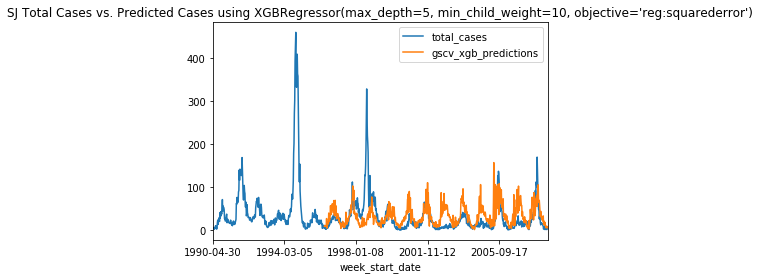

In [2280]:
#SJ: graph best GSCV XGB model

gscv_xgb_preds_sj = graph_gscv_preds(gscv_xgb_sj, full_pipeline, model, X_sj, y_train_sj, 'xgb')

The best XGBoost regressor trained on the SJ dataset performed slightly worse than the best random forest and still much better than the best Poisson regressor. Unlike the random forest, it also captured many of the peaks.

In [2226]:
#XGBoost Regressor (IQ)

gscv_xgb_iq = GridSearchCV(estimator=full_pipeline, param_grid=xgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv2)
gscv_xgb_iq.fit(X_iq, y_train_labels_iq)

print("Best parameter (CV score=%0.3f):" % gscv_xgb_iq.best_score_)
print(gscv_xgb_iq.best_params_)
print("all results:")
pd.DataFrame(gscv_xgb_iq.cv_results_)

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaco

Best parameter (CV score=-6.641):
{'model__max_depth': 5, 'model__min_child_weight': 1, 'model__objective': 'reg:squarederror', 'model__subsample': 1}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.217719      0.045903         0.021300        0.000321   
1         0.173826      0.036601         0.027992        0.000126   
2         0.213843      0.051644         0.026530        0.000666   
3         0.218103      0.037153         0.025643        0.000386   
4         0.179676      0.034316         0.020538        0.000490   
5         0.177850      0.025225         0.024850        0.000977   
6         0.210937      0.046289         0.022274        0.001155   
7         0.164955      0.031296         0.021136        0.000060   
8         0.193083      0.044497         0.022981        0.002057   
9         0.220580      0.051280         0.024634        0.002497   
10        0.169971      0.035523         0.023893        0.003389   
11        0.183243      0.051839         0.024142        0.004402   
12        0.193200      0.043428         0.026730        0.003939   
13        0.147283      0.024164         0.022756        0.000677   
14        0.182973      0.037013         0.021014        0.000492   
15        0.178211      0.041991         0.019912        0.000944   
16        0.148246      0.036315         0.020169        0.000999   
17        0.177923      0.050994         0.029544        0.007204   
18        0.180466      0.032910         0.020291        0.000002   
19        0.131913      0.034448         0.021486        0.004281   
20        0.149525      0.039308         0.020181        0.000221   
21        0.190662      0.045060         0.019646        0.001469   
22        0.149084      0.032331         0.022280        0.001389   
23        0.177409      0.020791         0.019477        0.000017   
24        0.388420      0.097151         0.026417        0.002427   
25        0.242664      0.054292         0.026338        0.004903   
26        0.356604      0.085652         0.025419        0.001090   
27        0.363234      0.085637         0.026063        0.002367   
28        0.260207      0.075845         0.022488        0.001374   
29        0.345156      0.093175         0.026410        0.000461   
30        0.376512      0.092201         0.027077        0.001002   
31        0.246922      0.072765         0.020604        0.000191   
32        0.345099      0.087668         0.025566        0.001199   
33        0.342215      0.080272         0.027004        0.003018   
34        0.248421      0.069372         0.023677        0.003347   
35        0.334145      0.083987         0.023449        0.001496   
36        0.348013      0.087468         0.020272        0.000997   
37        0.192548      0.068506         0.022762        0.002490   
38        0.292250      0.085019         0.024266        0.001414   
39        0.362723      0.098989         0.023293        0.001689   
40        0.236848      0.068102         0.029110        0.007000   
41        0.336310      0.074941         0.025253        0.003216   
42        0.294570      0.078666         0.021750        0.000359   
43        0.150592      0.056294         0.022161        0.002142   
44        0.241533      0.087018         0.022296        0.002555   
45        0.348125      0.110095         0.023499        0.001489   
46        0.222969      0.080822         0.027875        0.000670   
47        0.318344      0.102808         0.023302        0.001329   
48        0.484892      0.154342         0.023440        0.003075   
49        0.339182      0.084622         0.030420        0.002264   
50        0.453022      0.115338         0.023348        0.001354   
51        0.474666      0.151814         0.021769        0.001560   
52        0.305895      0.115099         0.025617        0.003359   
53        0.418600      0.130223         0.022963        0.000478   
54        0.482763      0.138798         0.026807        0.000722   
55        0.265257      0.087970         0.023760        0.001252   
56        0.443513      0.128881         0.022870        0.000313   
57 

In [2227]:
#XGB regressor with lowest mean absolute error (IQ)

pd.DataFrame(gscv_xgb_iq.cv_results_).loc[pd.DataFrame(gscv_xgb_iq.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.217719      0.045903           0.0213        0.000321   

  param_model__max_depth param_model__min_child_weight param_model__objective  \
0                      5                             1       reg:squarederror   

  param_model__subsample  \
0                      1   

                                                                                                                 params  \
0  {'model__max_depth': 5, 'model__min_child_weight': 1, 'model__objective': 'reg:squarederror', 'model__subsample': 1}   

   split0_test_score  split1_test_score  mean_test_score  std_test_score  \
0          -6.445978          -6.836441         -6.64121        0.195232   

   rank_test_score  
0                1

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


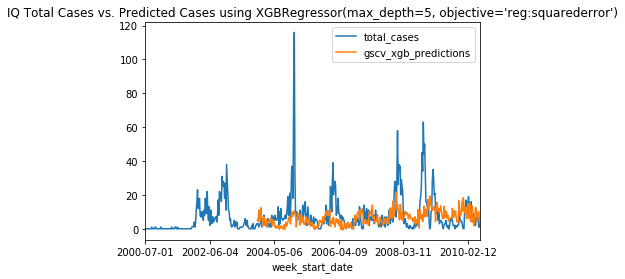

In [2228]:
#IQ: graph best GSCV XGB model

gscv_xgb_preds_iq = graph_gscv_preds(gscv_xgb_iq, full_pipeline, model, X_iq, y_train_iq, 'xgb')

The best XGBoost regressor on the IQ dataset performed worse than the random forest and the Poisson regressor during cross validation. However, it does seem to catch some of the peak periods, especially in later dates where the training set is large. 

#### HGB Regressor

In [2281]:
#HGB Regressor (SJ)

model = HistGradientBoostingRegressor(loss = 'poisson', random_state = 0)
hgb_parameters = {'model__learning_rate': [0.05, 0.1, 0.3], 'model__max_depth': [5, 10, 15], 'model__min_samples_leaf': [1, 5, 10], 'model__l2_regularization': [0, 0.5, 1, 5]}

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_hgb_sj = GridSearchCV(estimator=full_pipeline, param_grid=hgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_hgb_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_hgb_sj.best_score_)
print(gscv_hgb_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_hgb_sj.cv_results_)

Best parameter (CV score=-18.504):
{'model__l2_regularization': 1, 'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__min_samples_leaf': 1}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.237081      0.007483         0.030914        0.001695   
1         1.006193      0.080319         0.034027        0.007150   
2         0.791515      0.128362         0.035109        0.000320   
3         2.052165      0.034953         0.032838        0.002357   
4         2.037359      0.221681         0.034453        0.004523   
5         1.552287      0.293594         0.039295        0.002462   
6         2.326414      0.015554         0.033778        0.000946   
7         2.210078      0.100863         0.037934        0.001157   
8         1.860470      0.429536         0.030025        0.000942   
9         1.405216      0.016356         0.038875        0.008095   
10        1.053826      0.093087         0.035362        0.000150   
11        0.861000      0.137488         0.034811        0.001533   
12        2.918800      1.018781         0.038244        0.003993   
13        1.778535      0.138810         0.038940        0.000064   
14        1.362983      0.277768         0.042637        0.002826   
15        2.232646      0.035572         0.039174        0.004441   
16        2.032118      0.095860         0.041894        0.002837   
17        1.771845      0.394564         0.033052        0.002982   
18        1.231695      0.069426         0.034304        0.004579   
19        0.962276      0.070030         0.036762        0.002500   
20        0.804386      0.100095         0.036482        0.002248   
21        2.315544      0.048030         0.036468        0.004674   
22        1.905915      0.225957         0.041861        0.000414   
23        1.639795      0.187942         0.037342        0.000552   
24        2.693100      0.081964         0.034926        0.001971   
25        2.344278      0.096472         0.039465        0.008461   
26        2.122574      0.402204         0.040388        0.001281   
27        1.726015      0.042627         0.034874        0.000488   
28        1.405852      0.091384         0.038628        0.003355   
29        1.142159      0.196533         0.040850        0.002278   
30        3.066107      0.100311         0.034168        0.001134   
31        2.697310      0.228548         0.035584        0.000346   
32        2.201234      0.460509         0.039834        0.006122   
33        3.373047      0.122083         0.040490        0.001685   
34        3.006692      0.146685         0.038813        0.003125   
35        2.353619      0.420344         0.041778        0.000076   
36        1.884065      0.104817         0.039175        0.008254   
37        1.406669      0.065503         0.039943        0.005630   
38        1.148818      0.177747         0.032204        0.002519   
39        3.319823      0.510462         0.039031        0.004268   
40        1.671237      0.195409         0.036388        0.001961   
41        1.396724      0.236249         0.032341        0.000595   
42        2.165071      0.074063         0.039933        0.000113   
43        2.009927      0.129855         0.038414        0.000808   
44        1.678348      0.320326         0.036128        0.002058   
45        1.268629      0.107973         0.039245        0.000304   
46        0.912263      0.056719         0.033534        0.002740   
47        0.766610      0.091280         0.036964        0.002680   
48        2.260911      0.071656         0.037195        0.001802   
49        1.833035      0.194653         0.036283        0.003631   
50        1.580060      0.331069         0.038127        0.003532   
51        2.567083      0.010815         0.039414        0.000420   
52        2.248334      0.175391         0.036144        0.003763   
53        1.970494      0.309432         0.033502        0.007617   
54        1.755120      0.026420         0.041293        0.002623   
55        1.368061      0.102099         0.037101        0.000797   
56        1.028136      0.101027         0.046039        0.011794   
57 

In [2282]:
# pd.DataFrame(gscv_hgb_sj.cv_results_).loc[pd.DataFrame(gscv_hgb_sj.cv_results_).rank_test_score == 1]

In [2283]:
#HGB regressor with lowest mean absolute error (SJ)

pd.DataFrame(gscv_hgb_sj.cv_results_).loc[pd.DataFrame(gscv_hgb_sj.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
72       1.224559      0.033071         0.032129        0.001124   

   param_model__l2_regularization param_model__learning_rate  \
72                              1                        0.3   

   param_model__max_depth param_model__min_samples_leaf  \
72                      5                             1   

                                                                                                               params  \
72  {'model__l2_regularization': 1, 'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__min_samples_leaf': 1}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
72         -20.770327         -16.238454        -18.50439        2.265937   

    rank_test_score  
72                1

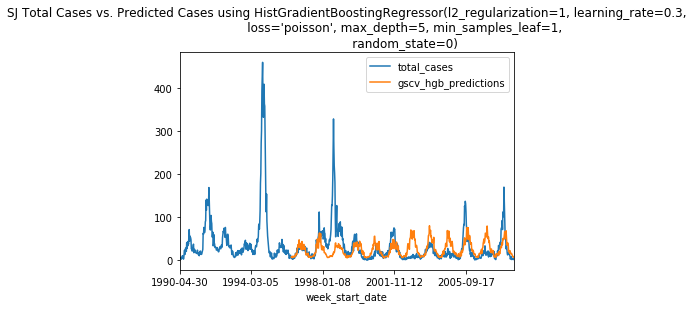

In [2284]:
#SJ: graph best GSCV HGB model

gscv_hgb_preds_sj = graph_gscv_preds(gscv_hgb_sj, full_pipeline, model, X_sj, y_train_sj, 'hgb')

In [2233]:
#HGB Regressor (IQ)

gscv_hgb_iq = GridSearchCV(estimator=full_pipeline, param_grid=hgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv2)
gscv_hgb_iq.fit(X_iq, y_train_labels_iq)

print("Best parameter (CV score=%0.3f):" % gscv_hgb_iq.best_score_)
print(gscv_hgb_iq.best_params_)
print("all results:")
pd.DataFrame(gscv_hgb_iq.cv_results_)

Best parameter (CV score=-6.707):
{'model__l2_regularization': 5, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 10}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.537843      0.034854         0.034643    6.585598e-03   
1         1.271328      0.053342         0.030329    4.658461e-03   
2         0.982833      0.078796         0.024853    3.343821e-04   
3         3.459437      0.493835         0.033839    7.733941e-03   
4         1.304381      0.258849         0.030588    2.868652e-03   
5         1.015232      0.336493         0.032211    2.331734e-04   
6         2.168107      0.002128         0.026507    4.211783e-03   
7         1.682935      0.329465         0.025103    7.486343e-05   
8         1.212695      0.374648         0.030545    3.538728e-03   
9         1.043877      0.138405         0.030476    1.633167e-03   
10        0.723287      0.077693         0.024603    2.637744e-03   
11        0.645239      0.052586         0.024713    1.217484e-03   
12        1.893967      0.169549         0.028025    7.834435e-04   
13        1.501148      0.252514         0.034167    2.188802e-03   
14        1.097050      0.273627         0.031260    1.028538e-03   
15        2.352956      0.086599         0.027135    4.843712e-03   
16        1.870499      0.325519         0.039973    4.768372e-07   
17        1.211307      0.404234         0.029612    1.829982e-03   
18        0.933906      0.142973         0.028470    1.251340e-03   
19        0.789601      0.104455         0.029907    2.072096e-03   
20        0.624760      0.067808         0.025801    3.124952e-03   
21        2.091155      0.263161         0.027148    5.875826e-04   
22        1.526288      0.327078         0.029582    3.412485e-03   
23        1.309530      0.192296         0.032676    6.546974e-04   
24        2.614486      0.008010         0.028050    3.992796e-03   
25        2.008622      0.419027         0.032869    6.432652e-03   
26        1.474986      0.486423         0.029361    5.769730e-05   
27        1.423091      0.147144         0.028323    6.155610e-03   
28        1.069667      0.036223         0.032377    3.988743e-04   
29        0.818178      0.016085         0.021938    4.507899e-03   
30        2.928084      0.005781         0.030679    6.806135e-03   
31        2.030768      0.533996         0.032900    2.100587e-03   
32        1.504386      0.295676         0.030579    8.059740e-04   
33        3.222380      0.023430         0.094143    5.824924e-03   
34        2.321396      0.588649         0.031979    2.384186e-07   
35        1.664331      0.624140         0.034208    5.698204e-04   
36        1.465324      0.007197         0.028651    8.499622e-05   
37        1.150808      0.072740         0.026845    5.132556e-03   
38        0.854237      0.077451         0.039664    1.036763e-02   
39        3.122994      0.094950         0.029730    6.882548e-03   
40        2.340697      0.803420         0.027662    3.045559e-03   
41        0.850690      0.231603         0.032161    3.207445e-03   
42        2.281581      0.109433         0.035034    5.087018e-03   
43        1.708139      0.368544         0.033998    1.453161e-04   
44        1.230158      0.448566         0.034711    1.408815e-03   
45        1.071265      0.060777         0.031714    1.292229e-03   
46        0.755024      0.091851         0.032460    8.214712e-04   
47        0.668797      0.068737         0.030836    7.889271e-04   
48        2.329516      0.028146         0.050940    1.096773e-02   
49        1.675079      0.187062         0.029365    2.709627e-04   
50        1.219688      0.315226         0.033508    2.159476e-03   
51        2.652229      0.037511         0.035905    2.375245e-03   
52        1.975313      0.345298         0.030349    1.120090e-03   
53        1.514290      0.585205         0.031539    4.972219e-04   
54        1.487134      0.153332         0.034872    5.786419e-04   
55        1.079441      0.013772         0.034558    1.491070e-03   
56        0.817406      0.066408         0.034439    4.746437e-03   
57 

In [2234]:
#HGB regressor with lowest mean absolute error (IQ)

pd.DataFrame(gscv_hgb_iq.cv_results_).loc[pd.DataFrame(gscv_hgb_iq.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
83       0.716618      0.001217         0.031743        0.005445   

   param_model__l2_regularization param_model__learning_rate  \
83                              5                       0.05   

   param_model__max_depth param_model__min_samples_leaf  \
83                      5                            10   

                                                                                                                 params  \
83  {'model__l2_regularization': 5, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 10}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
83          -6.848275          -6.566492        -6.707384        0.140892   

    rank_test_score  
83                1

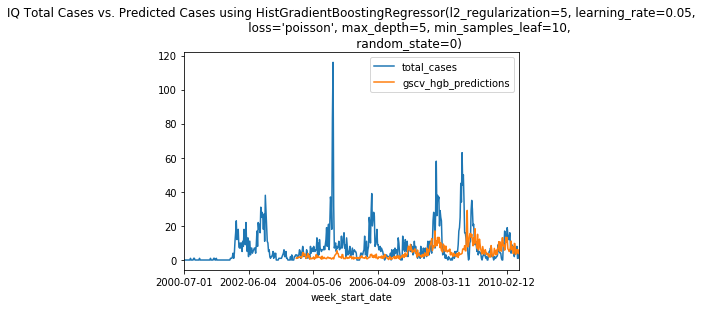

In [2235]:
#IQ: graph best GSCV HGB model

gscv_hgb_preds_iq = graph_gscv_preds(gscv_hgb_iq, full_pipeline, model, X_iq, y_train_iq, 'hgb')

#### KNN Regressor

In [2285]:
#KNN Regressor (SJ)

model = KNeighborsRegressor()
knn_parameters = {'model__n_neighbors': [5,10,30,50,70,90], 'model__weights': ['distance', 'uniform']}

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_knn_sj = GridSearchCV(estimator=full_pipeline, param_grid=knn_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_knn_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_knn_sj.best_score_)
print(gscv_knn_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_knn_sj.cv_results_)

Best parameter (CV score=-28.358):
{'model__n_neighbors': 90, 'model__weights': 'uniform'}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.041717      0.000621         0.036749        0.004201   
1        0.043473      0.007589         0.033969        0.005241   
2        0.042412      0.008853         0.045167        0.002474   
3        0.040206      0.008876         0.036339        0.005154   
4        0.041919      0.011719         0.041968        0.008162   
5        0.041873      0.008846         0.042574        0.008173   
6        0.047292      0.004716         0.043024        0.004515   
7        0.045251      0.012052         0.042852        0.008289   
8        0.043546      0.006398         0.046156        0.004316   
9        0.038839      0.008050         0.044293        0.000785   
10       0.037464      0.009390         0.057556        0.006706   
11       0.050097      0.010865         0.047209        0.000912   

   param_model__n_neighbors param_model__weights  \
0                         5             distance   
1                         5              uniform   
2                        10             distance   
3                        10              uniform   
4                        30             distance   
5                        30              uniform   
6                        50             distance   
7                        50              uniform   
8                        70             distance   
9                        70              uniform   
10                       90             distance   
11                       90              uniform   

                                                      params  \
0    {'model__n_neighbors': 5, 'model__weights': 'distance'}   
1     {'model__n_neighbors': 5, 'model__weights': 'uniform'}   
2   {'model__n_neighbors': 10, 'model__weights': 'distance'}   
3    {'model__n_neighbors': 10, 'model__weights': 'uniform'}   
4   {'model__n_neighbors': 30, 'model__weights': 'distance'}   
5    {'model__n_neighbors': 30, 'model__weights': 'uniform'}   
6   {'model__n_neighbors': 50, 'model__weights': 'distance'}   
7    {'model__n_neighbors': 50, 'model__weights': 'uniform'}   
8   {'model__n_neighbors': 70, 'model__weights': 'distance'}   
9    {'model__n_neighbors': 70, 'model__weights': 'uniform'}   
10  {'model__n_neighbors': 90, 'model__weights': 'distance'}   
11   {'model__n_neighbors': 90, 'model__weights': 'uniform'}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
0          -36.677060         -26.543093       -31.610077        5.066983   
1          -37.108333         -26.711538       -31.909936        5.198397   
2          -35.156669         -27.180426       -31.168547        3.988122   
3          -35.536859         -27.574359       -31.555609        3.981250   
4          -33.022067         -27.399023       -30.210545        2.811522   
5          -32.877137         -27.580556       -30.228846        2.648291   
6          -31.247442         -27.151324       -29.199383        2.048059   
7          -30.807500         -27.205000       -29.006250        1.801250   
8          -30.309936         -27.153065       -28.731500        1.578436   
9          -29.836401         -27.158425       -28.497413        1.338988   
10         -30.110698         -26.973905       -28.542302        1.568396   
11         -29.785541         -26.930093       -28.357817        1.427724   

    rank_test_score  
0                11  
1                12  
2                 9  
3                10  
4                 7  
5                 8  
6                 6  
7                 5  
8                 4  
9                 2  
10                3  
11                1

In [2286]:
#KNN regressor with lowest mean absolute error (SJ)

pd.DataFrame(gscv_knn_sj.cv_results_).loc[pd.DataFrame(gscv_knn_sj.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       0.050097      0.010865         0.047209        0.000912   

   param_model__n_neighbors param_model__weights  \
11                       90              uniform   

                                                     params  \
11  {'model__n_neighbors': 90, 'model__weights': 'uniform'}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
11         -29.785541         -26.930093       -28.357817        1.427724   

    rank_test_score  
11                1

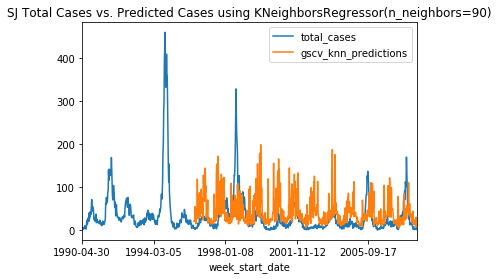

In [2287]:
#SJ: graph best GSCV KNN model

gscv_knn_preds_sj = graph_gscv_preds(gscv_knn_sj, full_pipeline, model, X_sj, y_train_sj, 'knn')

In [2239]:
#KNN Regressor (IQ)

gscv_knn_iq = GridSearchCV(estimator=full_pipeline, param_grid=knn_parameters, scoring = 'neg_mean_absolute_error', cv=tscv2)
gscv_knn_iq.fit(X_iq, y_train_labels_iq)

print("Best parameter (CV score=%0.3f):" % gscv_knn_iq.best_score_)
print(gscv_knn_iq.best_params_)
print("all results:")
pd.DataFrame(gscv_knn_iq.cv_results_)

Best parameter (CV score=-6.255):
{'model__n_neighbors': 50, 'model__weights': 'uniform'}
all results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.032715      0.008439         0.030554        0.000273   
1        0.030652      0.004724         0.026773        0.002930   
2        0.028786      0.003781         0.028846        0.001564   
3        0.026913      0.006053         0.026210        0.003954   
4        0.028810      0.010749         0.034193        0.005468   
5        0.026351      0.007733         0.032846        0.001394   
6        0.030623      0.002801         0.031146        0.000807   
7        0.027573      0.008200         0.035696        0.003951   
8        0.029446      0.005980         0.030385        0.003614   
9        0.028682      0.011252         0.038778        0.000338   
10       0.032672      0.006814         0.042197        0.001541   
11       0.035049      0.006801         0.030023        0.007404   

   param_model__n_neighbors param_model__weights  \
0                         5             distance   
1                         5              uniform   
2                        10             distance   
3                        10              uniform   
4                        30             distance   
5                        30              uniform   
6                        50             distance   
7                        50              uniform   
8                        70             distance   
9                        70              uniform   
10                       90             distance   
11                       90              uniform   

                                                      params  \
0    {'model__n_neighbors': 5, 'model__weights': 'distance'}   
1     {'model__n_neighbors': 5, 'model__weights': 'uniform'}   
2   {'model__n_neighbors': 10, 'model__weights': 'distance'}   
3    {'model__n_neighbors': 10, 'model__weights': 'uniform'}   
4   {'model__n_neighbors': 30, 'model__weights': 'distance'}   
5    {'model__n_neighbors': 30, 'model__weights': 'uniform'}   
6   {'model__n_neighbors': 50, 'model__weights': 'distance'}   
7    {'model__n_neighbors': 50, 'model__weights': 'uniform'}   
8   {'model__n_neighbors': 70, 'model__weights': 'distance'}   
9    {'model__n_neighbors': 70, 'model__weights': 'uniform'}   
10  {'model__n_neighbors': 90, 'model__weights': 'distance'}   
11   {'model__n_neighbors': 90, 'model__weights': 'uniform'}   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
0           -6.216786          -8.039616        -7.128201        0.911415   
1           -6.123699          -8.041618        -7.082659        0.958960   
2           -6.052235          -7.414232        -6.733233        0.680998   
3           -6.035260          -7.325434        -6.680347        0.645087   
4           -5.724004          -7.023332        -6.373668        0.649664   
5           -5.739884          -6.935260        -6.337572        0.597688   
6           -5.624816          -6.951123        -6.287970        0.663154   
7           -5.617803          -6.891676        -6.254740        0.636936   
8           -5.633668          -6.940853        -6.287261        0.653593   
9           -5.647069          -6.884476        -6.265772        0.618704   
10          -5.634318          -6.962648        -6.298483        0.664165   
11          -5.640462          -6.936031        -6.288247        0.647784   

    rank_test_score  
0                12  
1                11  
2                10  
3                 9  
4                 8  
5                 7  
6                 4  
7                 1  
8                 3  
9                 2  
10                6  
11                5

In [2240]:
#KNN regressor with lowest mean absolute error (IQ)

pd.DataFrame(gscv_knn_iq.cv_results_).loc[pd.DataFrame(gscv_knn_iq.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'rank_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.027573        0.0082         0.035696        0.003951   

  param_model__n_neighbors param_model__weights  \
7                       50              uniform   

                                                    params  split0_test_score  \
7  {'model__n_neighbors': 50, 'model__weights': 'uniform'}          -5.617803   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
7          -6.891676         -6.25474        0.636936                1

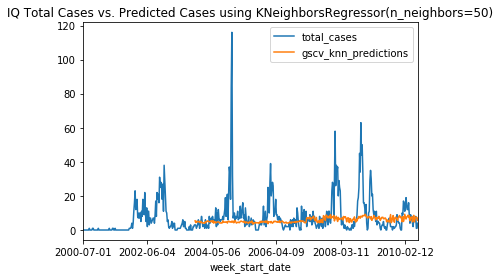

In [2241]:
#IQ: graph best GSCV KNN model

gscv_knn_preds_iq = graph_gscv_preds(gscv_knn_iq, full_pipeline, model, X_iq, y_train_iq, 'knn')

# Advanced Feature Engineering

### Preprocessing and Feature Engineering

In [2288]:
#Creating function to reflect the cyclical nature of week and month

def cycle(row):
    row.weekofyear = abs(np.sin(row.weekofyear * np.pi / 52))
    row.month = abs(np.sin(row.month * np.pi / 12))
    return row

In [2289]:
#Implementing cycle on X_train_sj_feat_eng and X_train_iq_feat_eng data sets

X_train_sj_feat_eng_adv = X_train_sj_feat_eng.apply(cycle, axis = 'columns')
X_train_iq_feat_eng_adv = X_train_iq_feat_eng.apply(cycle, axis = 'columns')

The cycle feature does not require being wrapped in a pipeline as it is independent of the data itself and therefore can not result in data leakage.

In [2290]:
#Dropping one of perfectly correlated variables (precipitation_amt_mm and reanalysis_sat_precip_amt_mm)

X_train_sj_feat_eng_adv = X_train_sj_feat_eng_adv.drop('precipitation_amt_mm', axis = 1)
X_train_iq_feat_eng_adv = X_train_iq_feat_eng_adv.drop('precipitation_amt_mm', axis = 1)

In [2291]:
#Custom Transformer for NDVI variables

class NDVI_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, city): 
        self.city = city
    
    #Return self, nothing else to do here
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        if self.city == 'sj':
#             X = pd.DataFrame(X, index = X_sj.index, columns = ndvi_cols)
#             X.loc[:,'ndvi_north'] = (X.loc[:, 'ndvi_ne']**2 + X.loc[:, 'ndvi_nw']**2) / 2
#             X.loc[:,'ndvi_south'] = (X.loc[:, 'ndvi_se']**2 + X.loc[:, 'ndvi_sw']**2) / 2

            #because the original X has been transformed (scaled and imputed), it comes in as an array (and not a df)
            ndvi_north = (X[:, 0]**2 + X[:, 1]**2) / 2
            ndvi_south = (X[:, 2]**2 + X[:, 3]**2) / 2
            ndvi_north = ndvi_north.reshape((X.shape[0], 1))
            ndvi_south = ndvi_south.reshape((X.shape[0], 1))
            X = np.append(X, ndvi_north, axis = 1)
            X = np.append(X, ndvi_south, axis = 1)
            
        if self.city == 'iq':
            ndvi_all = (X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2 + X[:, 3]**2) / 4
            ndvi_all = ndvi_all.reshape((X.shape[0], 1))
            X = np.append(X, ndvi_all, axis = 1)

#             X = pd.DataFrame(X, index = X_iq.index, columns = ndvi_cols)
#             X.loc[:,'ndvi_all'] = (X.loc[:, 'ndvi_ne']**2 + X.loc[:, 'ndvi_nw']**2 + X.loc[:, 'ndvi_se']**2 + X.loc[:, 'ndvi_sw']**2) / 4
        
#         return X.drop(['ndvi_ne', 'ndvi_se', 'ndvi_nw', 'ndvi_sw'], axis = 1)

        #drop the first four columns, which are the original NDVI columns as they are the first four columns passed through the ColumnTransformer
        return X[:, 4:]

In [2292]:
#Advanced preprocessing pipeline

std_scaler = StandardScaler()
knn_imputer = KNNImputer(weights = 'distance')

ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
X_adv_sj = X_train_sj_feat_eng_adv.select_dtypes(include=['float64', 'int64'])
X_adv_iq = X_train_iq_feat_eng_adv.select_dtypes(include=['float64', 'int64'])
remaining_cols = [col for col in X_adv_sj.columns if col not in ndvi_cols]

sj_ndvi_transf = NDVI_Transformer(city = 'sj')
iq_ndvi_transf = NDVI_Transformer(city = 'iq')

sj_ndvi_pipeline = Pipeline(steps = [
    ('scale', std_scaler),
    ('impute', knn_imputer), 
    ('ndvi_feat_eng', sj_ndvi_transf)
])

iq_ndvi_pipeline = Pipeline(steps = [
    ('scale', std_scaler),
    ('impute', knn_imputer), 
    ('ndvi_feat_eng', iq_ndvi_transf)
])

remaining_cols_pipeline = Pipeline(steps = [
    ('scale', std_scaler),
    ('impute', knn_imputer)
])

sj_preprocessor_pipeline = ColumnTransformer(transformers = [
    ('sj_ndvi_transf', sj_ndvi_pipeline, ndvi_cols),
    ('sj_remain_transf', remaining_cols_pipeline, [col for col in X_adv_sj.columns if col not in ndvi_cols])],
    remainder = 'passthrough')

iq_preprocessor_pipeline = ColumnTransformer(transformers = [
    ('iq_ndvi_transf', iq_ndvi_pipeline, ndvi_cols),
    ('iq_remain_transf', remaining_cols_pipeline, [col for col in X_adv_iq.columns if col not in ndvi_cols])], 
    remainder = 'passthrough')

sj_preprocessor_pipeline.fit_transform(X_adv_sj)[0]
iq_preprocessor_pipeline.fit_transform(X_adv_iq)[0]

array([ 1.0308466 , -1.71498585,  1.17686506, -0.96553092, -0.51326425,
       -0.21802793,  0.09125501,  0.14043899, -0.28703214,  0.4988367 ,
       -1.10376298, -0.30787295, -0.11373441, -1.22818819,  0.13612482,
       -1.13640611, -0.39447346, -0.94118813, -1.6337921 ,  1.05705159])

Random forests and boosting are invariant to scaling, but distance is used to fit support vector regression and k-nearest neighbors regression. Therefore, we scaled the non-NDVI columns to help improve performance of those models.

In [2293]:
#Create function that divides dataset into folds using TimeSeriesSplit
##tscv_train_dict, tscv_val_dict are dictionaries

def create_folds(X):
    tscv_train_dict = {}
    tscv_val_dict = {}
    fold_num = 0
    
    if X.equals(X_adv_sj):
        ts = tscv
    else:
        ts = tscv2
    
    for train_index, val_index in ts.split(X):
        fold_num += 1
        tscv_train_dict[fold_num] = X.iloc[train_index]
        tscv_val_dict[fold_num] = X.iloc[val_index]
    
    return tscv_train_dict, tscv_val_dict

In [2294]:
#Create function that preprocesses the training and validation sets using the preprocessing pipeline
##train_fold and val_fold are dataframes

def preprocess(X_train, X_val, pipeline, cols):
    train_fold = pd.DataFrame(pipeline.fit_transform(X_train), index = X_train.index, columns = cols)
    val_fold = pd.DataFrame(pipeline.transform(X_val), index = X_val.index, columns = cols)
    
    return train_fold, val_fold

In [2295]:
#Create function that creates a rolling window for the columns specified
##X_train_rolling, X_val_rolling are dataframes with new 'rolling' columns

def rolling_inputs(X_train, X_val, cols, window):
    #by combining the train and validation sets, we are able to retrieve train data to create the first couple of entries in the
    #rolling columns of the valid set. This does not lead to leakage as the information flows from train to validation, not vice versa
    full_fold_df = pd.concat((X_train, X_val))
    for col in cols:
        rolling_col_name = '{}_rolling_{}'.format(col, window)
#         full_fold_df[rolling_col_name] = full_fold_df[col].rolling(window, 1).mean()
        full_fold_df[rolling_col_name] = full_fold_df[col].shift(window, axis = 0).fillna(0)
    X_train_rolling = full_fold_df.loc[X_train.index]
    X_val_rolling = full_fold_df.loc[X_val.index]
    return X_train_rolling, X_val_rolling

It is likely that a mosquito carrying dengue fever can spread the disease for several weeks after it first contracts the virus. Therefore, many of the cases in a given week could be a result of weather patterns occurring several weeks before. As a result, we will create rolling features that take into account previous weeks to see if these can lead to better predictions. 

In [2296]:
#Create functions that uses previous week's `total_cases` (real or predicted) as an input for the current week

def prev_total_cases(X_train, X_val, y):
    X_train['previous_week_total_cases'] = y.loc[X_train.index].shift(periods=1, fill_value=0)
    
    #creating the same column, `previous_week_total_cases`, in X_val and changing the earliest week to have the last week's value, 
    #which comes from X_train. All other values are converted to -1, to indicate an impossible prediction given these values are non-negative counts
    X_val['previous_week_total_cases'] = -1
    X_val.previous_week_total_cases.iloc[0] = y.loc[X_train.index].iloc[-1]
    return X_train, X_val

def last_prediction_as_input(X_val, idx, pred = None):
    #take the most recent preciction (which will start with the earliest week in X_val) 
    #and add it to the `previous_week_total_cases` of the next week
    X_val.previous_week_total_cases.loc[idx+1] = pred
    return X_val
    

Additionally, given the contagious nature of the virus, previous weeks' case counts could be an important predictor for the current week's. We've added the last week's `total_cases` as an input to predict the current week's `total_cases` in the training folds. In the validation folds, the first week is taken from the last week of the training fold (since the time series split orders the folds chronologically) and every input following is the predicted `total_cases`.

In [2297]:
#Create function that makes predictions sequentially and uses last_prediction_as_input function to generate input data for current week

def predict_seq(X_val, model):
    pred_list = []
    for idx in X_val.index:
#         pred = model.predict(np.array(X_val.loc[idx]).reshape(1,-1))
        pred = model.predict(X_val.loc[idx].to_frame().transpose())
        pred_list.append(float(pred))
        if idx != X_val.index.max():
            X_val = last_prediction_as_input(X_val, idx, pred)
    return pred_list, X_val

Cross-validation offered through sci-kit learn can not be used given that we need to combine the folds in order to add these extra inputs. This will not result in data leakage as no information from the validation fold will be used when training the training folds.

In [2298]:
#Create function that replicates (the most important columns from) a row of the GridSearchCV dataframe

def gscv_df(mae_dict, params):
    cols = []
    data = []
    for fold_n, fold_score in mae_dict.items():
        #creating lists of the split scores for each fold and the corresponding column names
        cols.append('split{}_score'.format(fold_n))
        data.append(fold_score)
    
    #adding the mean score to the list of scores and column names
    cols.append('mean_score')
    mean_score = np.array(data).mean()
    data.append(mean_score)
    data = np.array(data).reshape(1,-1)
    
    #creating df with cv scores for each fold and the mean score of all folds
    df = pd.DataFrame(data = data, columns = cols)
    
    #adding the model's parameters to the df
    df['model_params'] = params

    #rearranging the columns so that the parameters are first
    df_cols = df.columns.tolist()
    df_cols = df_cols[-1:] + df_cols[:-1]
    df = df[df_cols]    
    return df

In [2299]:
#Creating function for preprocessing, adding additional rolling features, and storing cv folds into dictionaries
##Returns dictionaries of train and validation folds

def prep_for_model(X, window_size):
    
    if X.equals(X_adv_sj):
        cols_transf = ['ndvi_north', 'ndvi_south'] + sj_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_north', 'ndvi_south']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_sj.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = sj_preprocessor_pipeline
        y_train_labels = y_train_labels_sj
        ts = tscv
    elif X.equals(X_adv_iq):
        cols_transf = ['ndvi_all'] + iq_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_all']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_iq.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = iq_preprocessor_pipeline
        y_train_labels = y_train_labels_iq 
        ts = tscv2

    #creating folds on X
    tscv_train_dict, tscv_val_dict = create_folds(X)

    #preprocessing the folds and replacing the raw data with the processed data in the dictionaries
    for fold_n in [x+1 for x in list(range(ts.n_splits))]:
        train_fold, val_fold = preprocess(tscv_train_dict[fold_n], tscv_val_dict[fold_n], preprocessor_pipeline, cols_transf)
        tscv_train_dict[fold_n] = train_fold
        tscv_val_dict[fold_n] = val_fold
            
        #adding rolling inputs to folds and storing in dictionaries
        train_fold_rolling, val_fold_rolling = rolling_inputs(train_fold, val_fold, rolling_cols, window_size)
        tscv_train_dict[fold_n] = train_fold_rolling
        tscv_val_dict[fold_n] = val_fold_rolling

        #adding previous_week_total_cases as an input to folds and storing in dictionaries
        train_fold_pw, val_fold_pw = prev_total_cases(tscv_train_dict[fold_n], tscv_val_dict[fold_n], y_train_labels)
        tscv_train_dict[fold_n] = train_fold_pw
        tscv_val_dict[fold_n] = val_fold_pw
    
    return tscv_train_dict, tscv_val_dict

In [2300]:
#Create function that performs cross-validation on the advanced feature engineering
##Returns df with results of cross-validation and predictions of each model

def cv_adv(X, window_size, model, parameters):
    
    #Create dictionaries of preprocessed and feature-engineered folds for cross-validation
    tscv_train_dict, tscv_val_dict = prep_for_model(X, window_size)
    
    param_n = 0
    mae_dict = {}
    pred_dict = {}
    
    if X_adv_sj.equals(X):
        y = y_train_labels_sj
        ts = tscv
    else:
        y = y_train_labels_iq
        ts = tscv2

    #finding all combinations of parameters for the model to be used in cv
    keys = parameters.keys()
    values = [parameters[key] for key in keys]
    param_combos = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

    for param in param_combos:
        model = model.set_params(**param)

        param_n += 1
        pred_dict[param_n] = {}

        for fold_n in [x+1 for x in list(range(ts.n_splits))]:
            #retrieving the preprocessed and feature-engineered train and validation folds
            train = tscv_train_dict[fold_n]
            val = tscv_val_dict[fold_n]

            #defining indeces of the current train and validation fold
            train_index = train.index
            val_index = val.index

            #defining y_train and y_val that correspond to the train and validation sets of the current fold
            y_train = y.loc[train_index]
            y_val = y.loc[val_index]

            #training the model on the training part of the fold
            model.fit(train, y_train)

            #making predictions on validation set, one at a time, and adding past prediction as input to current week
            pred_list, _ = predict_seq(val, model)
            pred_dict[param_n][fold_n] = pred_list
    #         pred_list = model.predict(val)

            #calculating mae and storing in a dictionary (rewrites over mae_dict of past parameters)
            mae_dict[fold_n] = mean_absolute_error(pred_list, y_val)

        #combine all dataframes of different parameters into one
        if param_n == 1:
            cv_df = gscv_df(mae_dict, str(param))
        else:
            cv_df = cv_df.append(gscv_df(mae_dict, str(param)), ignore_index = True)

    #add rank column based on lowest MAE score        
    cv_df['rank'] = cv_df.mean_score.rank(ascending = True, method = 'first')
    return cv_df, pred_dict

In [2301]:
#Function that adds predictions of best model (model with parameters that had the lowest MAE score during gridsearch cv) to y_train

def add_preds_to_y(cv_df, pred_dict, model, X, y, model_name):
    val_preds = []
    val_indeces = []
    
    if X_adv_sj.equals(X):
        ts = tscv
    else:
        ts = tscv2
    
    for train_index, val_index in ts.split(X):
        val_indeces += list(val_index)
     
    #finding parameters of model that performed best during cv
    #adding 1 to align param_n with cv_df as the dictionary keys for param_n start at 1 whereas the cv_df index starts at 0
    best_param = cv_df.loc[cv_df['rank'] == 1].model_params.index[0] + 1
    
    #retrieving predictions from model with best_param
    for key in pred_dict[best_param].keys():
        val_preds += pred_dict[best_param][key]

    if X.equals(X_adv_sj):
        city = 'SJ'
        gscv_adv_preds = pd.DataFrame(val_preds, index = val_indeces, columns = ['gscv_adv_{}_predictions'.format(model_name)])
    else:
        city = 'IQ'
        starting_index = y.index.min()
        val_indeces_new = [idx + starting_index for idx in val_indeces]
        gscv_adv_preds = pd.DataFrame(val_preds, index = val_indeces_new, columns = ['gscv_adv_{}_predictions'.format(model_name)])
    return gscv_adv_preds, city

In [2302]:
#Function that graphs `total_cases` and the predictions found during cross validation of the best model 

def graph_gscv_adv_preds(cv_df, pred_dict, model, X, y, model_name):
    y_labels = y.total_cases
    gscv_adv_preds, city = add_preds_to_y(cv_df, pred_dict, model, X, y, model_name)
    gscv_adv_preds = y.join(gscv_adv_preds, how = 'left')
    gscv_adv_preds[['week_start_date','total_cases', 'gscv_adv_{}_predictions'.format(model_name)]].set_index('week_start_date').plot()
    plt.title('{} Total Cases vs. Predicted Cases using {}'.format(city, model.set_params(**eval(cv_df.loc[cv_df['rank'] == 1].model_params.values[0]))))
    return gscv_adv_preds

### Modeling

#### XGBoost Regressor

Before modeling, we'll use the XGBoost regressor to determine the optimal window size for our rolling variables. 

In [2372]:
#Running CV on XGBoost regressors with different window sizes (SJ)

xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_parameters = {'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 5, 10], 'subsample': [1, 1/3, 2/3]}

window_size_list = [0,1,2,3,4,5,6,7]

for w in window_size_list:
    print(w)
    cv_df_xgb, pred_dict_xgb = cv_adv(X_adv_sj, w, xgb_model, xgb_parameters)
    if w == window_size_list[0]:
        score_by_window_df = cv_df_xgb.loc[cv_df_xgb['rank'] == 1]
    else:
        score_by_window_df = score_by_window_df.append(cv_df_xgb.loc[cv_df_xgb['rank'] == 1], ignore_index = True)

score_by_window_df['window_size'] = window_size_list
score_by_window_df['w_rank'] = score_by_window_df.mean_score.rank(ascending = True, method = 'first')

score_by_window_df

0


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

1


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

2


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

3


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

4


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

5


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

6


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

7


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

model_params  \
0  {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
1   {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
2  {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
3  {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
4                   {'max_depth': 10, 'min_child_weight': 1, 'subsample': 1}   
5  {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
6  {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
7  {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   

   split1_score  split2_score  mean_score  rank  window_size  w_rank  
0     20.728549     13.702859   17.215704   1.0            0     4.0  
1     20.133906     14.683333   17.408620   1.0            1     6.0  
2     19.320963     14.708080   17.014522   1.0            2     2.0  
3     19.339172     15.772979   17.556075   1.0            3     8.0  
4     19.389806     15.151583   17.270694   1.0            4     5.0  
5     16.691536     16.097089   16.394313   1.0            5     1.0  
6     20.330986     13.925100   17.128043   1.0            6     3.0  
7     18.412150     16.470104   17.441127   1.0            7     7.0

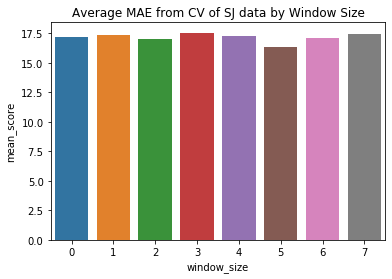

In [2373]:
#Graphing the average MAE from CV by window size (SJ)

y = score_by_window_df.mean_score
x = score_by_window_df.window_size
sns.barplot(x = x, y = y)
plt.title('Average MAE from CV of SJ data by Window Size')
plt.show()

A window size of 5 weeks results in the lowest mean cross-validated score for the best XGBoost model. This, in combination with domain knowledge that the type of mosquitoes that carry the virus have a lifespan between two and four weeks and that the time from infection to symptoms is about 4 to 7 days, leads us to believe that a window size of 5 weeks is reasonable. We could add window size as a hyperparameter to tune during cross validation but the window size is more of a reflection on dengue fever than the model's particular characteristics. As a result, we can feel confident that 5 weeks is most likely appropriate across all models. 

In [2374]:
#Running CV on XGBoost regressors with different window sizes (IQ)

xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_parameters = {'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 5, 10], 'subsample': [1, 1/3, 2/3]}

window_size_list = [0,1,2,3,4,5,6,7]

for w in window_size_list:
    print(w)
    cv_df_xgb, pred_dict_xgb = cv_adv(X_adv_iq, w, xgb_model, xgb_parameters)
    if w == window_size_list[0]:
        score_by_window_df = cv_df_xgb.loc[cv_df_xgb['rank'] == 1]
    else:
        score_by_window_df = score_by_window_df.append(cv_df_xgb.loc[cv_df_xgb['rank'] == 1], ignore_index = True)

score_by_window_df['window_size'] = window_size_list
score_by_window_df['w_rank'] = score_by_window_df.mean_score.rank(ascending = True, method = 'first')

score_by_window_df

0


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

1


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

2


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

3


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

4


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

5


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

6


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

7


C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

model_params  \
0  {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
1                  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 1}   
2                   {'max_depth': 20, 'min_child_weight': 1, 'subsample': 1}   
3  {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
4  {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
5  {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
6                    {'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}   
7  {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   

   split1_score  split2_score  mean_score  rank  window_size  w_rank  
0      6.618301      7.776387    7.197344   1.0            0     6.0  
1      6.607187      6.923305    6.765246   1.0            1     1.0  
2      6.934872      7.128702    7.031787   1.0            2     5.0  
3      6.783563      6.948754    6.866159   1.0            3     3.0  
4      7.693538      6.976613    7.335075   1.0            4     7.0  
5      7.564970      7.116259    7.340614   1.0            5     8.0  
6      6.501797      7.096222    6.799010   1.0            6     2.0  
7      5.881411      7.865956    6.873683   1.0            7     4.0

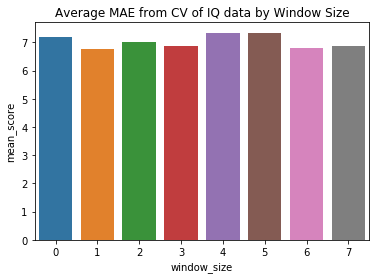

In [2375]:
#Graphing the average MAE from CV by window size (IQ)

y = score_by_window_df.mean_score
x = score_by_window_df.window_size
sns.barplot(x = x, y = y)
plt.title('Average MAE from CV of IQ data by Window Size')
plt.show()

In [2376]:
#SJ: Finding the best XGBoost model via cross validation

xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_parameters = {'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 5, 10], 'subsample': [1, 1/3, 2/3]}

cv_df_xgb_sj, pred_dict_xgb_sj = cv_adv(X_adv_sj, 5, xgb_model, xgb_parameters)
cv_df_xgb_sj

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

model_params  \
0                      {'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}   
1     {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
2     {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
3                      {'max_depth': 5, 'min_child_weight': 2, 'subsample': 1}   
4     {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
5     {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
6                      {'max_depth': 5, 'min_child_weight': 5, 'subsample': 1}   
7     {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
8     {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
9                     {'max_depth': 5, 'min_child_weight': 10, 'subsample': 1}   
10   {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
11   {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
12                    {'max_depth': 10, 'min_child_weight': 1, 'subsample': 1}   
13   {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
14   {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
15                    {'max_depth': 10, 'min_child_weight': 2, 'subsample': 1}   
16   {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
17   {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
18                    {'max_depth': 10, 'min_child_weight': 5, 'subsample': 1}   
19   {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
20   {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
21                   {'max_depth': 10, 'min_child_weight': 10, 'subsample': 1}   
22  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
23  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
24                    {'max_depth': 15, 'min_child_weight': 1, 'subsample': 1}   
25   {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
26   {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
27                    {'max_depth': 15, 'min_child_weight': 2, 'subsample': 1}   
28   {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
29   {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
30                    {'max_depth': 15, 'min_child_weight': 5, 'subsample': 1}   
31   {'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
32   {'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
33                   {'max_depth': 15, 'min_child_weight': 10, 'subsample': 1}   
34  {'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
35  {'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
36                    {'max_depth': 20, 'min_child_weight': 1, 'subsample': 1}   
37   {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
38   {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
39                    {'max_depth': 20, 'min_child_weight': 2, 'subsample': 1}   
40   {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
41   {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
42                    {'max_depth': 20, 'min_child_weight': 5, 'subsample': 1}   
43   {'max_depth': 20, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
44   {'max_depth': 20, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
45                   {'max_depth': 20, 'min_child_weight': 10, 'subsample': 1}   
46  {'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
47  {'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   

    split1_score  split2_score  mean_score  ran

In [2377]:
#XGB regressor with lowest mean absolute error (SJ)

cv_df_xgb_sj.loc[cv_df_xgb_sj['rank'] == 1]

model_params  \
37  {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   

    split1_score  split2_score  mean_score  rank  
37     16.691536     16.097089   16.394313   1.0

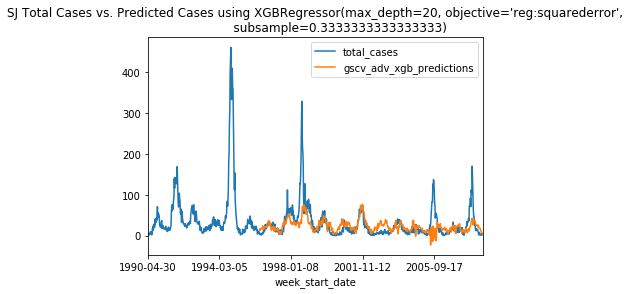

In [2378]:
#SJ: Graphing the predictions generated during CV of the best XGBoost model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_xgb_sj = graph_gscv_adv_preds(cv_df_xgb_sj, pred_dict_xgb_sj, xgb_model, X_adv_sj, y_train_sj, 'xgb')

In [2379]:
#IQ: Finding the best XGBoost model via cross validation

cv_df_xgb_iq, pred_dict_xgb_iq = cv_adv(X_adv_iq, 6, xgb_model, xgb_parameters)
cv_df_xgb_iq

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and w

model_params  \
0                      {'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}   
1     {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
2     {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
3                      {'max_depth': 5, 'min_child_weight': 2, 'subsample': 1}   
4     {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
5     {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
6                      {'max_depth': 5, 'min_child_weight': 5, 'subsample': 1}   
7     {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
8     {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
9                     {'max_depth': 5, 'min_child_weight': 10, 'subsample': 1}   
10   {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
11   {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
12                    {'max_depth': 10, 'min_child_weight': 1, 'subsample': 1}   
13   {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
14   {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
15                    {'max_depth': 10, 'min_child_weight': 2, 'subsample': 1}   
16   {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
17   {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
18                    {'max_depth': 10, 'min_child_weight': 5, 'subsample': 1}   
19   {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
20   {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
21                   {'max_depth': 10, 'min_child_weight': 10, 'subsample': 1}   
22  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
23  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
24                    {'max_depth': 15, 'min_child_weight': 1, 'subsample': 1}   
25   {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
26   {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
27                    {'max_depth': 15, 'min_child_weight': 2, 'subsample': 1}   
28   {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
29   {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
30                    {'max_depth': 15, 'min_child_weight': 5, 'subsample': 1}   
31   {'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
32   {'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
33                   {'max_depth': 15, 'min_child_weight': 10, 'subsample': 1}   
34  {'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
35  {'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   
36                    {'max_depth': 20, 'min_child_weight': 1, 'subsample': 1}   
37   {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.3333333333333333}   
38   {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.6666666666666666}   
39                    {'max_depth': 20, 'min_child_weight': 2, 'subsample': 1}   
40   {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.3333333333333333}   
41   {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6666666666666666}   
42                    {'max_depth': 20, 'min_child_weight': 5, 'subsample': 1}   
43   {'max_depth': 20, 'min_child_weight': 5, 'subsample': 0.3333333333333333}   
44   {'max_depth': 20, 'min_child_weight': 5, 'subsample': 0.6666666666666666}   
45                   {'max_depth': 20, 'min_child_weight': 10, 'subsample': 1}   
46  {'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.3333333333333333}   
47  {'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.6666666666666666}   

    split1_score  split2_score  mean_score  ran

In [2380]:
#XGB regressor with lowest mean absolute error (IQ)

cv_df_xgb_iq.loc[cv_df_xgb_iq['rank'] == 1]

model_params  split1_score  \
0  {'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}      6.501797   

   split2_score  mean_score  rank  
0      7.096222     6.79901   1.0

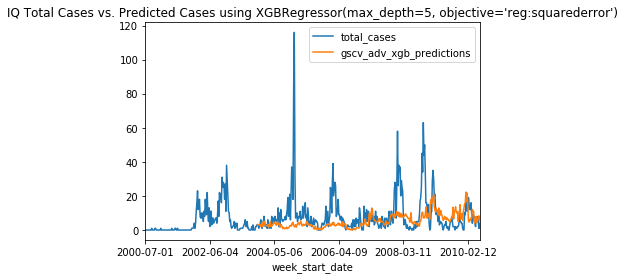

In [2381]:
# IQ: Graphing the predictions generated during CV of the best XGBoost model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_xgb_iq = graph_gscv_adv_preds(cv_df_xgb_iq, pred_dict_xgb_iq, xgb_model, X_adv_iq, y_train_iq, 'xgb')

#### Random Forest Regressor

In [2382]:
#SJ: Finding the best RF model via cross validation

rf_model = RandomForestRegressor(criterion = 'mae', random_state = 0)
rf_parameters = {'n_estimators': [2, 5, 10, 20], 'max_depth': [5, 10, 15, 20, None], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 1/3]}

cv_df_rf_sj, pred_dict_rf_sj = cv_adv(X_adv_sj, 5, rf_model, rf_parameters)
cv_df_rf_sj

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  \
0                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}   
1                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
2         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
3                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'auto'}   
4                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
5         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
6                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 'auto'}   
7                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
8         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
9                    {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'auto'}   
10                   {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
11       {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
12                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 'auto'}   
13                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
14       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
15                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 'auto'}   
16                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
17       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
18                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'auto'}   
19                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
20       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
21                  {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 'auto'}   
22                  {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
23      {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
24                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'auto'}   
25                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
26       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
27                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'auto'}   
28                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
29       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
30                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 'auto'}   
31                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
32       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
33                  {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'auto'}   
34                  {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
35      {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
36                   {'n_estimators': 2, 'max_depth': 20, 'min_samples_leaf': 1, 'max_features':

In [2383]:
#RF regressor with lowest mean absolute error (SJ)

cv_df_rf_sj.loc[cv_df_rf_sj['rank'] == 1]

model_params  \
27  {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'auto'}   

    split1_score  split2_score  mean_score  rank  
27     19.096154     15.255609   17.175881   1.0

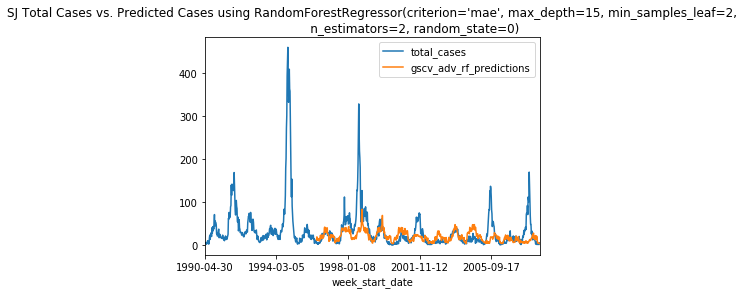

In [2384]:
#SJ: Graphing the predictions generated during CV of the best RF model

gscv_adv_preds_rf_sj = graph_gscv_adv_preds(cv_df_rf_sj, pred_dict_rf_sj, rf_model, X_adv_sj, y_train_sj, 'rf')

In [2385]:
#IQ: Finding the best RF model via cross validation

cv_df_rf_iq, pred_dict_rf_iq = cv_adv(X_adv_iq, 6, rf_model, rf_parameters)
cv_df_rf_iq

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  \
0                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}   
1                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
2         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
3                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'auto'}   
4                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
5         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
6                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 'auto'}   
7                     {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
8         {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
9                    {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'auto'}   
10                   {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
11       {'n_estimators': 2, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
12                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 'auto'}   
13                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
14       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
15                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 'auto'}   
16                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
17       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
18                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'auto'}   
19                   {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
20       {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
21                  {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 'auto'}   
22                  {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
23      {'n_estimators': 2, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
24                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'auto'}   
25                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}   
26       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 0.3333333333333333}   
27                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'auto'}   
28                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}   
29       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 0.3333333333333333}   
30                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 'auto'}   
31                   {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt'}   
32       {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 0.3333333333333333}   
33                  {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'auto'}   
34                  {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}   
35      {'n_estimators': 2, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   
36                   {'n_estimators': 2, 'max_depth': 20, 'min_samples_leaf': 1, 'max_features':

In [2386]:
#RF regressor with lowest mean absolute error (IQ)

cv_df_rf_iq.loc[cv_df_rf_iq['rank'] == 1]

model_params  \
131  {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 0.3333333333333333}   

     split1_score  split2_score  mean_score  rank  
131      5.313295      6.681503    5.997399   1.0

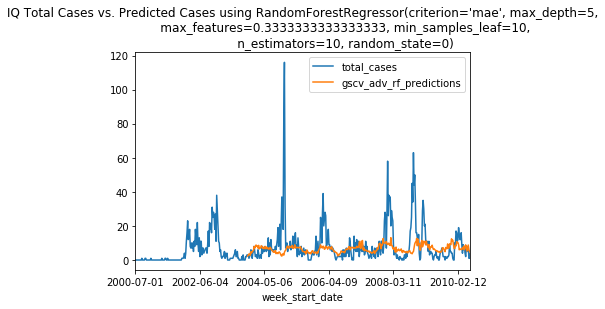

In [2387]:
#IQ: Graphing the predictions generated during CV of the best RF model

gscv_adv_preds_rf_iq = graph_gscv_adv_preds(cv_df_rf_iq, pred_dict_rf_iq, rf_model, X_adv_iq, y_train_iq, 'rf')

#### Histogram Gradient Boosting

In [2388]:
#SJ: Finding the best HGBoost model via cross validation

hgb_model = HistGradientBoostingRegressor(loss = 'poisson', random_state = 0)
hgb_parameters = {'learning_rate': [0.05, 0.1, 0.3], 'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 5, 10], 'l2_regularization': [0, 0.5, 1, 5]}

cv_df_hgb_sj, pred_dict_hgb_sj = cv_adv(X_adv_sj, 5, hgb_model, hgb_parameters)
cv_df_hgb_sj

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  \
0        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0}   
1      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
2        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 1}   
3        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 5}   
4        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0}   
5      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
6        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 1}   
7        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 5}   
8       {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 0}   
9     {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
10      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 1}   
11      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 5}   
12      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0}   
13    {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
14      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 1}   
15      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 5}   
16      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0}   
17    {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
18      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 1}   
19      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 5}   
20     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 0}   
21   {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
22     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 1}   
23     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 5}   
24      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 0}   
25    {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
26      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 1}   
27      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 5}   
28      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 0}   
29    {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
30      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 1}   
31      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 5}   
32     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 0}   
33   {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
34     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 1}   
35     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 5}   
36        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0}   
37      {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
38        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 1}   
39        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 5}   
40        {'learning_rat

In [2389]:
#HGBoost regressor with lowest mean absolute error (SJ)

pd.set_option('display.max_colwidth', 1000)
cv_df_hgb_sj.loc[cv_df_hgb_sj['rank'] == 1]
# cv_df_hgb_sj.loc[cv_df_hgb_sj.split4_score < 17]

model_params  \
103  {'learning_rate': 0.3, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 5}   

     split1_score  split2_score  mean_score  rank  
103      19.16757      13.33735    16.25246   1.0

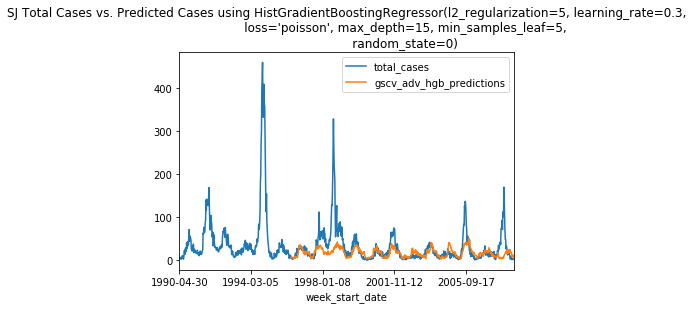

In [2390]:
#SJ: Graphing the predictions generated during CV of the best HistGradBoosting model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_hgb_sj = graph_gscv_adv_preds(cv_df_hgb_sj, pred_dict_hgb_sj, hgb_model, X_adv_sj, y_train_sj, 'hgb')

In [2391]:
#IQ: Finding the best HGBoost model via cross validation

cv_df_hgb_iq, pred_dict_hgb_iq = cv_adv(X_adv_iq, 6, hgb_model, hgb_parameters)
cv_df_hgb_iq

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  \
0        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0}   
1      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
2        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 1}   
3        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 5}   
4        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0}   
5      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
6        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 1}   
7        {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 5}   
8       {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 0}   
9     {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
10      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 1}   
11      {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 5}   
12      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0}   
13    {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
14      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 1}   
15      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 5}   
16      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0}   
17    {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
18      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 1}   
19      {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 5}   
20     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 0}   
21   {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
22     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 1}   
23     {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 10, 'l2_regularization': 5}   
24      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 0}   
25    {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
26      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 1}   
27      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 1, 'l2_regularization': 5}   
28      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 0}   
29    {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 0.5}   
30      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 1}   
31      {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 5}   
32     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 0}   
33   {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 0.5}   
34     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 1}   
35     {'learning_rate': 0.05, 'max_depth': 15, 'min_samples_leaf': 10, 'l2_regularization': 5}   
36        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0}   
37      {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.5}   
38        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 1}   
39        {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 5}   
40        {'learning_rat

In [2392]:
#HGBoost regressor with lowest mean absolute error (IQ)

pd.set_option('display.max_colwidth', 1000)
cv_df_hgb_iq.loc[cv_df_hgb_iq['rank'] == 1]

model_params  \
4  {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0}   

   split1_score  split2_score  mean_score  rank  
4      6.514698      7.133671    6.824185   1.0

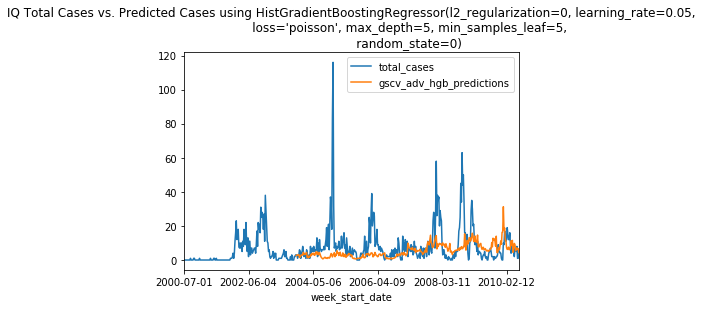

In [2393]:
#IQ: Graphing the predictions generated during CV of the best HistGradBoosting model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_hgb_iq = graph_gscv_adv_preds(cv_df_hgb_iq, pred_dict_hgb_iq, hgb_model, X_adv_iq, y_train_iq, 'hgb')

#### KNN Regression

In [2394]:
#SJ: Finding the best KNN model via cross validation

knn_model = KNeighborsRegressor()
knn_parameters = {'n_neighbors': [5,10,30,50,70,90], 'weights': ['distance', 'uniform']}

cv_df_knn_sj, pred_dict_knn_sj = cv_adv(X_adv_sj, 5, knn_model, knn_parameters)
cv_df_knn_sj

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  split1_score  split2_score  \
0    {'n_neighbors': 5, 'weights': 'distance'}     20.672699     18.033834   
1     {'n_neighbors': 5, 'weights': 'uniform'}     21.265385     32.166026   
2   {'n_neighbors': 10, 'weights': 'distance'}     22.134965     15.105479   
3    {'n_neighbors': 10, 'weights': 'uniform'}     21.297756     14.984615   
4   {'n_neighbors': 30, 'weights': 'distance'}     19.438337     15.041405   
5    {'n_neighbors': 30, 'weights': 'uniform'}     19.292949     15.297115   
6   {'n_neighbors': 50, 'weights': 'distance'}     19.637353     15.370226   
7    {'n_neighbors': 50, 'weights': 'uniform'}     19.840064     15.515769   
8   {'n_neighbors': 70, 'weights': 'distance'}     20.414679     15.853250   
9    {'n_neighbors': 70, 'weights': 'uniform'}     20.720925     16.084799   
10  {'n_neighbors': 90, 'weights': 'distance'}     20.906736     16.172196   
11   {'n_neighbors': 90, 'weights': 'uniform'}     21.432799     16.448825   

    mean_score  rank  
0    19.353266  11.0  
1    26.715705  12.0  
2    18.620222   9.0  
3    18.141186   6.0  
4    17.239871   1.0  
5    17.295032   2.0  
6    17.503790   3.0  
7    17.677917   4.0  
8    18.133965   5.0  
9    18.402862   7.0  
10   18.539466   8.0  
11   18.940812  10.0

In [2395]:
#KNN regressor with lowest mean absolute error (SJ)

cv_df_knn_sj.loc[cv_df_knn_sj['rank'] == 1]

model_params  split1_score  split2_score  \
4  {'n_neighbors': 30, 'weights': 'distance'}     19.438337     15.041405   

   mean_score  rank  
4   17.239871   1.0

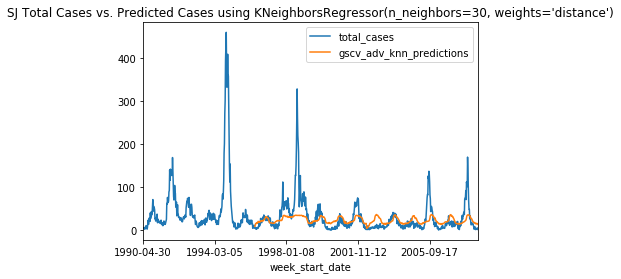

In [2396]:
#SJ: Graphing the predictions generated during CV of the best KNN model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_knn_sj = graph_gscv_adv_preds(cv_df_knn_sj, pred_dict_knn_sj, knn_model, X_adv_sj, y_train_sj, 'knn')

In [2397]:
#IQ: Finding the best KNN model via cross validation

cv_df_knn_iq, pred_dict_knn_iq = cv_adv(X_adv_iq, 6, knn_model, knn_parameters)
cv_df_knn_iq

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se

model_params  split1_score  split2_score  \
0    {'n_neighbors': 5, 'weights': 'distance'}      6.747517      6.856294   
1     {'n_neighbors': 5, 'weights': 'uniform'}      6.779191      7.012717   
2   {'n_neighbors': 10, 'weights': 'distance'}      6.746822      6.796337   
3    {'n_neighbors': 10, 'weights': 'uniform'}      6.762428      6.750289   
4   {'n_neighbors': 30, 'weights': 'distance'}      6.873390      6.982046   
5    {'n_neighbors': 30, 'weights': 'uniform'}      6.883430      7.018112   
6   {'n_neighbors': 50, 'weights': 'distance'}      7.085906      6.951400   
7    {'n_neighbors': 50, 'weights': 'uniform'}      7.114335      6.988092   
8   {'n_neighbors': 70, 'weights': 'distance'}      7.166576      6.909055   
9    {'n_neighbors': 70, 'weights': 'uniform'}      7.208092      6.915772   
10  {'n_neighbors': 90, 'weights': 'distance'}      7.108883      6.897160   
11   {'n_neighbors': 90, 'weights': 'uniform'}      7.125177      6.873282   

    mean_score  rank  
0     6.801905   3.0  
1     6.895954   4.0  
2     6.771579   2.0  
3     6.756358   1.0  
4     6.927718   5.0  
5     6.950771   6.0  
6     7.018653   9.0  
7     7.051214  11.0  
8     7.037816  10.0  
9     7.061932  12.0  
10    7.003021   8.0  
11    6.999229   7.0

In [2398]:
#KNN regressor with lowest mean absolute error (IQ)

cv_df_knn_iq.loc[cv_df_knn_iq['rank'] == 1]

model_params  split1_score  split2_score  \
3  {'n_neighbors': 10, 'weights': 'uniform'}      6.762428      6.750289   

   mean_score  rank  
3    6.756358   1.0

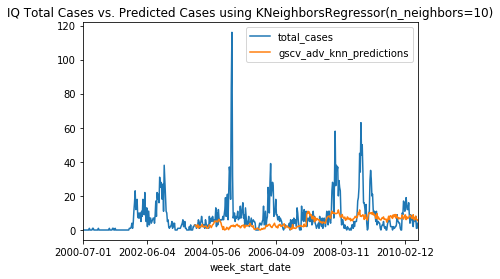

In [2399]:
#IQ: Graphing the predictions generated during CV of the best KNN model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_knn_iq = graph_gscv_adv_preds(cv_df_knn_iq, pred_dict_knn_iq, knn_model, X_adv_iq, y_train_iq, 'knn')

### Comparing Models

Text(0.5, 1.0, 'Average MAE of Models Tuned during Cross Validation')

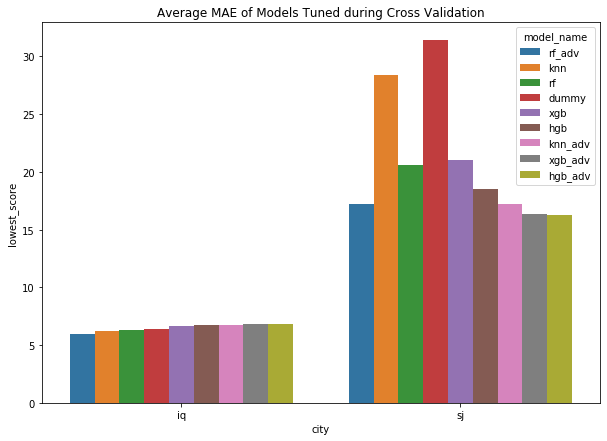

In [2400]:
#Graphing mean CV scores to show best model in each city

best_model_scores = {'xgb_adv_sj':cv_df_xgb_sj, 'rf_adv_sj':cv_df_rf_sj, 'hgb_adv_sj':cv_df_hgb_sj, 'knn_adv_sj':cv_df_knn_sj, 'xgb_adv_iq':cv_df_xgb_iq, 'rf_adv_iq':cv_df_rf_iq, 'hgb_adv_iq':cv_df_hgb_iq, 'knn_adv_iq':cv_df_knn_iq, 
                     'rf_iq':pd.DataFrame(gscv_rf_iq.cv_results_), 'rf_sj':pd.DataFrame(gscv_rf_sj.cv_results_), 'xgb_iq':pd.DataFrame(gscv_xgb_iq.cv_results_), 'xgb_sj':pd.DataFrame(gscv_xgb_sj.cv_results_), 
                     'knn_iq':pd.DataFrame(gscv_knn_iq.cv_results_), 'knn_sj':pd.DataFrame(gscv_knn_sj.cv_results_), 'hgb_iq':pd.DataFrame(gscv_hgb_iq.cv_results_), 'hgb_sj':pd.DataFrame(gscv_hgb_sj.cv_results_)}

city_list = []
mn_list = []
ls = []

ls.append(abs(cv_dummy_iq.mean()))
ls.append(abs(cv_dummy_sj.mean()))

city_list.append('iq')
city_list.append('sj')

mn_list.append('dummy')
mn_list.append('dummy')

df = pd.DataFrame()

for k, df_mae in best_model_scores.items():
    city = k.split('_')[-1]
    model_name = '_'.join(k.split('_')[:-1])
    mn_list.append(model_name)
    city_list.append(city)
    
    if len(k.split('_')) == 3:  #for models with advanced preprocessing (adv)
        ls.append(df_mae.loc[df_mae['rank'] == 1].mean_score.values[0])
    else:
        ls.append(abs(df_mae.loc[df_mae['rank_test_score'] == 1].mean_test_score.values[0]))

df['city'] = city_list
df['lowest_score'] = ls
df['model_name'] = mn_list
df.sort_values(by=['lowest_score'], ascending = True, inplace=True)

fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'city', y = 'lowest_score', hue = 'model_name', ax = ax, data = df)
# sns.barplot(x = 'model_name', y = 'lowest_score', ax = ax, data = df.loc[df.city == 'iq'])
plt.title('Average MAE of Models Tuned during Cross Validation')


There are a couple of key takeaways we can take from this chart. First, only two of the models (the KNN using advanced feature engineering and the KNN using minimal preprocessing) performed better than the dummy regressor in IQ whereas all models performed better than the dummy regressor in SJ. This is likely due to the smaller spread of `total_cases` in IQ (the nature of the data) or the fewer number of data points available. We also see that, for each model, the advanced feature engineering did not gaurantee better results than the preliminary processing. The advanced preprocessing lowered most models' MAE scores in SJ and raised them in SJ. 

According to the results of cross-validation, to best model IQ, we should use the advanced preprocessing with the KNN model. For SJ, we should use the HistGradientBoosting model with advanced preprocessing to achieve the lowest MAE. The fact that we have to use different models for each city demonstrates the importance of splitting the dataset in this case.

In [2401]:
def compare_models(**gscv_adv_preds_dict):
    k_num = 0
    for k, df in gscv_adv_preds_dict.items():
        k_num += 1
        df['mae_{}'.format(k)] = abs(df.total_cases - df['gscv_{}_predictions'.format(k)])
        if k_num == 1:
            df_maes = df
        else:
            df_maes = df_maes.join(df['mae_{}'.format(k)], how = 'left')

    return df_maes

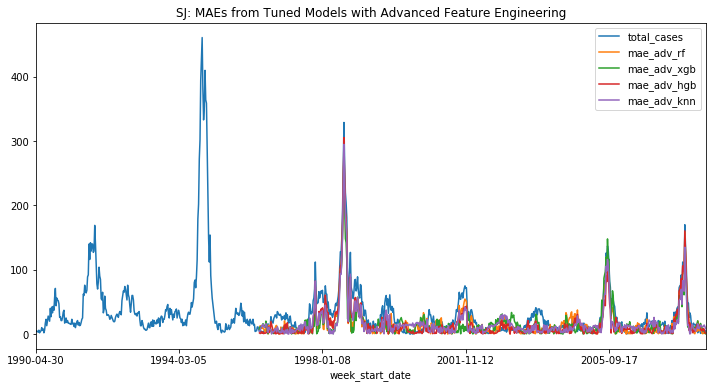

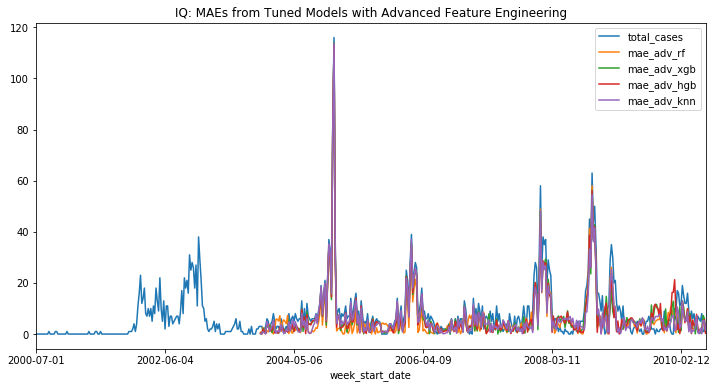

In [2402]:
#SJ: Model comparison of MAE for each prediction generated through CV

model_comparison_sj = compare_models(**{'adv_rf':gscv_adv_preds_rf_sj, 'adv_xgb':gscv_adv_preds_xgb_sj, 'adv_hgb': gscv_adv_preds_hgb_sj, 'adv_knn': gscv_adv_preds_knn_sj})
model_comparison_sj[['total_cases', 'mae_adv_rf', 'mae_adv_xgb', 'mae_adv_hgb', 'mae_adv_knn', 'week_start_date']].set_index('week_start_date').plot(figsize=(12,6))
plt.title('SJ: MAEs from Tuned Models with Advanced Feature Engineering')

model_comparison_iq = compare_models(**{'adv_rf':gscv_adv_preds_rf_iq, 'adv_xgb':gscv_adv_preds_xgb_iq, 'adv_hgb': gscv_adv_preds_hgb_iq, 'adv_knn': gscv_adv_preds_knn_iq})
model_comparison_iq[['total_cases', 'mae_adv_rf', 'mae_adv_xgb', 'mae_adv_hgb', 'mae_adv_knn', 'week_start_date']].set_index('week_start_date').plot(figsize=(12,6))
plt.title('IQ: MAEs from Tuned Models with Advanced Feature Engineering')

plt.show()

However, as the charts above show, some models perform better than others for certain predictions. We can try ensemble methods as a method to improve our predictions by using the "strengths" of each model to help in formulating a final prediction.

### Ensembles

Combining predictions from different models can potentially lead to more accurate predictions.

In [2403]:
#SJ: Summary of performance of models

df_sj = df.loc[df.city == 'sj']
print('Advanced HGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'hgb_adv'].lowest_score.values[0]))
print('Advanced XGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'xgb_adv'].lowest_score.values[0]))
print('Advanced RF: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'rf_adv'].lowest_score.values[0]))
print('Advanced KNN: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'knn_adv'].lowest_score.values[0]))
print('HGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'hgb'].lowest_score.values[0]))
print('XGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'xgb'].lowest_score.values[0]))
print('RF: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'rf'].lowest_score.values[0]))
print('KNN: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'knn'].lowest_score.values[0]))

Advanced HGB: 16.25
Advanced XGB: 16.39
Advanced RF: 17.18
Advanced KNN: 17.24
HGB: 18.50
XGB: 21.05
RF: 20.62
KNN: 28.36


In [2405]:
#SJ: Simple averages of model predictions and their respective average MAE obtained through CV

first_pred_idx_sj = gscv_adv_preds_rf_sj.loc[gscv_adv_preds_rf_sj.notnull().all(axis = 1)].index.min()

print('Averaging all advanced models: {:.2f}'.format(mean_absolute_error((gscv_adv_preds_rf_sj.loc[first_pred_idx_sj:].gscv_adv_rf_predictions + gscv_adv_preds_hgb_sj.loc[first_pred_idx_sj:].gscv_adv_hgb_predictions + gscv_adv_preds_knn_sj.loc[first_pred_idx_sj:].gscv_adv_knn_predictions + gscv_adv_preds_xgb_sj.loc[first_pred_idx_sj:].gscv_adv_xgb_predictions)/4, y_train_labels_sj.loc[first_pred_idx_sj:])))
print('Averaging all regular models: {:.2f}'.format(mean_absolute_error((gscv_xgb_preds_sj.loc[first_pred_idx_sj:].gscv_xgb_predictions + gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions + gscv_knn_preds_sj.loc[first_pred_idx_sj:].gscv_knn_predictions)/3, y_train_labels_sj.loc[first_pred_idx_sj:])))
print('Averaging rf and hgb regular models: {:.2f}'.format(mean_absolute_error((gscv_hgb_preds_sj.loc[first_pred_idx_sj:].gscv_hgb_predictions + gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions)/2, y_train_labels_sj.loc[first_pred_idx_sj:])))

Averaging all advanced models: 15.86
Averaging all regular models: 27.06
Averaging rf and hgb regular models: 23.51


Taking a simple average of the predictions generated through cross-validation of the models with advanced preprocessing led to a lower MAE than any of the individual models. However, we can possibly do even better if we can find the optimal balance of the models. The simplest way to do this is by applying a weighted average ensemble. 

In [2406]:
#Finds all combinations of normalized (sum to 1) weights for a given number of models

def ensemble_coeffs(n_models):
    weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#     weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    weights_dict = {}
    for n in list(range(n_models)):
        weights_dict[n+1] = weights
                  
    keys = weights_dict.keys()
    values = [weights_dict[key] for key in keys]
    non_normalized_combos = [combination for combination in itertools.product(*values)]
    normalized_combos = []
    for i in non_normalized_combos:
        array = np.array(i)
        normalized_values = array / sum(array)
        normalized_combos.append(list(normalized_values))
    non_repeating_normalized_combos = []
    for j in normalized_combos:
        if (j not in non_repeating_normalized_combos and np.array(j).sum() == 1):
            non_repeating_normalized_combos.append(j)
    return non_repeating_normalized_combos

In [2407]:
#Calculates a weighted average of the predictions that were generated through CV and outputs the average MAE 

def weighted_avg_ensemble(*model_preds, city):
    dot_product_preds = {}
    i = 0
    n_models = len(model_preds)
    non_repeating_normalized_combos = ensemble_coeffs(n_models)
    for weights in non_repeating_normalized_combos:
        given_weights_dict = {}
        for n in range(n_models):
            given_weights_dict[n] = weights[n] * np.array(model_preds[n])
        dot_product_preds[i] = sum(given_weights_dict.values())
        i+=1
    
    #Because cross-validation was done with TimeSeriesSplit, there are no predictions for the first fold of the data
    if city == 'sj':
        y = y_train_labels_sj.loc[first_pred_idx_sj:]
    elif city == 'iq':
        y = y_train_labels_iq.loc[first_pred_idx_iq:]
    
    mae_weights_dict = {}
    for l in range(len(ensemble_coeffs(len(model_preds)))):
        mae_weights_dict[l] = mean_absolute_error(dot_product_preds[l], y)
    return mae_weights_dict, non_repeating_normalized_combos

In [2408]:
#SJ: Finding the weighted average of base models that leads to the lowest average MAE during cross-validation

#Advanced models
adv_models_list = ['rf_adv', 'hgb_adv', 'knn_adv', 'xgb_adv']
mae_weights_dict_adv_sj, non_repeating_normalized_combos_adv_sj = weighted_avg_ensemble(gscv_adv_preds_rf_sj.loc[first_pred_idx_sj:].gscv_adv_rf_predictions, gscv_adv_preds_hgb_sj.loc[first_pred_idx_sj:].gscv_adv_hgb_predictions, gscv_adv_preds_knn_sj.loc[first_pred_idx_sj:].gscv_adv_knn_predictions, gscv_adv_preds_xgb_sj.loc[first_pred_idx_sj:].gscv_adv_xgb_predictions, city = 'sj')

mwd_keys_adv_sj = list(mae_weights_dict_adv_sj.keys())
mwd_values_adv_sj = list(mae_weights_dict_adv_sj.values())

min_mae_adv_sj = min(mae_weights_dict_adv_sj.values())
min_mae_coeffs_adv_sj = non_repeating_normalized_combos_adv_sj[mwd_values_adv_sj.index(min_mae_adv_sj)]

#Preliminary models
reg_models_list = ['hgb', 'rf', 'knn', 'xgb']
mae_weights_dict_sj, non_repeating_normalized_combos_sj = weighted_avg_ensemble(gscv_hgb_preds_sj.loc[first_pred_idx_sj:].gscv_hgb_predictions, gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions, gscv_knn_preds_sj.loc[first_pred_idx_sj:].gscv_knn_predictions, gscv_xgb_preds_sj.loc[first_pred_idx_sj:].gscv_xgb_predictions, city = 'sj')

mwd_keys_sj = list(mae_weights_dict_sj.keys())
mwd_values_sj = list(mae_weights_dict_sj.values())

min_mae_sj = min(mae_weights_dict_sj.values())
min_mae_coeffs_sj = non_repeating_normalized_combos_sj[mwd_values_sj.index(min_mae_sj)]

print('The minimum average MAE for SJ obtained by a weighted average of the advanced base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_adv_sj, [round(num, 3) for num in min_mae_coeffs_adv_sj], adv_models_list))
print()
print('The minimum average MAE for SJ obtained by a weighted average of the regular base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_sj, [round(num, 3) for num in min_mae_coeffs_sj], reg_models_list))

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


The minimum average MAE for SJ obtained by a weighted average of the advanced base predictors is 15.56. The coefficients are [0.059, 0.529, 0.0, 0.412] for ['rf_adv', 'hgb_adv', 'knn_adv', 'xgb_adv'] models, respectively.

The minimum average MAE for SJ obtained by a weighted average of the regular base predictors is 19.15. The coefficients are [0.909, 0.0, 0.0, 0.091] for ['hgb', 'rf', 'knn', 'xgb'] models, respectively.


In [2409]:
#IQ: Summary of performance of models

df_iq = df.loc[df.city == 'iq']
print('Advanced HGB: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'hgb_adv'].lowest_score.values[0]))
print('Advanced XGB: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'xgb_adv'].lowest_score.values[0]))
print('Advanced RF: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'rf_adv'].lowest_score.values[0]))
print('Advanced KNN: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'knn_adv'].lowest_score.values[0]))
print('HGB: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'hgb'].lowest_score.values[0]))
print('XGB: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'xgb'].lowest_score.values[0]))
print('RF: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'rf'].lowest_score.values[0]))
print('KNN: {:.2f}'.format(df_iq.loc[df_iq.model_name == 'knn'].lowest_score.values[0]))

Advanced HGB: 6.82
Advanced XGB: 6.80
Advanced RF: 6.00
Advanced KNN: 6.76
HGB: 6.71
XGB: 6.64
RF: 6.30
KNN: 6.25


In [2410]:
#IQ: Simple averages of model predictions and their respective average MAE obtained through CV

first_pred_idx_iq = gscv_adv_preds_rf_iq.loc[gscv_adv_preds_rf_iq.notnull().all(axis = 1)].index.min()

print('Averaging all advanced models: {:.2f}'.format(mean_absolute_error((gscv_adv_preds_rf_iq.loc[first_pred_idx_iq:].gscv_adv_rf_predictions + gscv_adv_preds_hgb_iq.loc[first_pred_idx_iq:].gscv_adv_hgb_predictions + gscv_adv_preds_knn_iq.loc[first_pred_idx_iq:].gscv_adv_knn_predictions + gscv_adv_preds_xgb_iq.loc[first_pred_idx_iq:].gscv_adv_xgb_predictions)/4, y_train_labels_iq.loc[first_pred_idx_iq:])))
print('Averaging all regular models: {:.2f}'.format(mean_absolute_error((gscv_xgb_preds_iq.loc[first_pred_idx_iq:].gscv_xgb_predictions + gscv_rf_preds_iq.loc[first_pred_idx_iq:].gscv_rf_predictions + gscv_knn_preds_iq.loc[first_pred_idx_iq:].gscv_knn_predictions)/3, y_train_labels_iq.loc[first_pred_idx_iq:])))
print('Averaging knn and rf models: {:.2f}'.format(mean_absolute_error((gscv_rf_preds_iq.loc[first_pred_idx_iq:].gscv_rf_predictions + gscv_knn_preds_iq.loc[first_pred_idx_iq:].gscv_knn_predictions)/2, y_train_labels_iq.loc[first_pred_idx_iq:])))

Averaging all advanced models: 6.37
Averaging all regular models: 6.37
Averaging knn and rf models: 6.31


In [2411]:
#IQ: Finding the weighted average of base models that leads to the lowest average MAE during cross-validation

# gscv_rf_preds_iq.loc[1066:].gscv_rf_predictions, gscv_knn_preds_iq.loc[1066:].gscv_knn_predictions, gscv_xgb_preds_iq.loc[1066:].gscv_xgb_predictions, gscv_adv_preds_rf_iq.loc[1066:].gscv_adv_rf_predictions, gscv_adv_preds_hgb_iq.loc[1066:].gscv_adv_hgb_predictions, gscv_adv_preds_knn_iq.loc[1066:].gscv_adv_knn_predictions, gscv_adv_preds_xgb_iq.loc[1066:].gscv_adv_xgb_predictions

#Advanced models
mae_weights_dict_adv_iq, non_repeating_normalized_combos_adv_iq = weighted_avg_ensemble(gscv_adv_preds_rf_iq.loc[first_pred_idx_iq:].gscv_adv_rf_predictions, gscv_adv_preds_hgb_iq.loc[first_pred_idx_iq:].gscv_adv_hgb_predictions, gscv_adv_preds_knn_iq.loc[first_pred_idx_iq:].gscv_adv_knn_predictions, gscv_adv_preds_xgb_iq.loc[first_pred_idx_iq:].gscv_adv_xgb_predictions, city = 'iq')

mwd_keys_adv_iq = list(mae_weights_dict_adv_iq.keys())
mwd_values_adv_iq = list(mae_weights_dict_adv_iq.values())

min_mae_adv_iq = min(mae_weights_dict_adv_iq.values())
min_mae_coeffs_adv_iq = non_repeating_normalized_combos_adv_iq[mwd_values_adv_iq.index(min_mae_adv_iq)]

#Preliminary models
mae_weights_dict_iq, non_repeating_normalized_combos_iq = weighted_avg_ensemble(gscv_hgb_preds_iq.loc[first_pred_idx_iq:].gscv_hgb_predictions, gscv_rf_preds_iq.loc[first_pred_idx_iq:].gscv_rf_predictions, gscv_knn_preds_iq.loc[first_pred_idx_iq:].gscv_knn_predictions, gscv_xgb_preds_iq.loc[first_pred_idx_iq:].gscv_xgb_predictions, city = 'iq')

mwd_keys_iq = list(mae_weights_dict_iq.keys())
mwd_values_iq = list(mae_weights_dict_iq.values())

min_mae_iq = min(mae_weights_dict_iq.values())
min_mae_coeffs_iq = non_repeating_normalized_combos_iq[mwd_values_iq.index(min_mae_iq)]

print('The minimum average MAE for IQ obtained by a weighted average of the advanced base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_adv_iq, [round(num, 3) for num in min_mae_coeffs_adv_iq], adv_models_list))
print()
print('The minimum average MAE for IQ obtained by a weighted average of the regular base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_iq, [round(num, 3) for num in min_mae_coeffs_iq], reg_models_list))

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


The minimum average MAE for IQ obtained by a weighted average of the advanced base predictors is 5.98. The coefficients are [0.833, 0.0, 0.083, 0.083] for ['rf_adv', 'hgb_adv', 'knn_adv', 'xgb_adv'] models, respectively.

The minimum average MAE for IQ obtained by a weighted average of the regular base predictors is 6.27. The coefficients are [0.0, 0.222, 0.778, 0.0] for ['hgb', 'rf', 'knn', 'xgb'] models, respectively.


We see that for both SJ and IQ, a weighted average of the advanced models results in the lowest average cross-validated MAE. Therefore, we'll make our predictions on the test set using these weights. Stacking is another ensemble method that could be applied. Because of the time series nature of the data and the advanced feature engineering, we would need to create our own meta-model, which may be explored in future analysis.

### Predictions

In [2412]:
#Applying feature engineering to X_test datasets

#Regular Feature Engineering

#Adding month and day features from week_start_date
sj_week_start_date = pd.to_datetime(X_test_sj.week_start_date)
X_test_sj['day'] = sj_week_start_date.map(lambda x: x.day)
X_test_sj['month'] = sj_week_start_date.map(lambda x: x.month)

iq_week_start_date = pd.to_datetime(X_test_iq.week_start_date)
X_test_iq['day'] = iq_week_start_date.map(lambda x: x.day)
X_test_iq['month'] = iq_week_start_date.map(lambda x: x.month)

#Implementing weekofyear_function on X_test_sj and X_test_iq data sets
sj_test_years_with_53 = years_with_53_weeks(X_test_sj)
iq_test_years_with_53 = years_with_53_weeks(X_test_iq)

X_test_sj_feat_eng = X_test_sj.apply(lambda x: weekofyear_function(x, sj_test_years_with_53), axis = 'columns')
X_test_iq_feat_eng = X_test_iq.apply(lambda x: weekofyear_function(x, iq_test_years_with_53), axis = 'columns')

#Selecting only numeric columns

X_test_sj_feat_eng = X_test_sj_feat_eng.select_dtypes(include=['float64', 'int64'])
X_test_iq_feat_eng = X_test_iq_feat_eng.select_dtypes(include=['float64', 'int64'])

#Advanced Feature Engineering

#Implementing cycle on X_test_sj_feat_eng and X_test_iq_feat_eng data sets
X_test_sj_feat_eng_adv = X_test_sj_feat_eng.apply(cycle, axis = 'columns')
X_test_iq_feat_eng_adv = X_test_iq_feat_eng.apply(cycle, axis = 'columns')

#Selecting only numeric columns
X_test_sj_feat_eng_adv = X_test_sj_feat_eng_adv.select_dtypes(include=['float64', 'int64'])
X_test_iq_feat_eng_adv = X_test_iq_feat_eng_adv.select_dtypes(include=['float64', 'int64'])

#Dropping one of perfectly correlated variables (precipitation_amt_mm and reanalysis_sat_precip_amt_mm)
X_test_adv_sj = X_test_sj_feat_eng_adv.drop('precipitation_amt_mm', axis = 1)
X_test_adv_iq = X_test_iq_feat_eng_adv.drop('precipitation_amt_mm', axis = 1)

#Changing indeces of X_test dataframes to be compatible with rolling_inputs function so that test set index 
#starts 1 after last index of train set
test_index_list_sj = list(range(len(X_test_pp_sj)))
test_index_list_sj = [idx + 1 + X_sj.index.max() for idx in test_index_list_sj]
X_test_adv_sj.set_index(pd.Index(test_index_list_sj), inplace = True)

test_index_list_iq = list(range(len(X_test_pp_iq)))
test_index_list_iq = [idx + 1 + X_iq.index.max() for idx in test_index_list_iq]
X_test_adv_iq.set_index(pd.Index(test_index_list_iq), inplace = True)

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [2413]:
#Creating function for preprocessing and adding additional rolling features
##Only difference between this and prep_for_model is that we are not performing CV
##Returns advanced processed dataframes of train and test sets

def prep_for_final_model(X_train, X_test, window_size, city):
    if city == 'sj':
        cols_transf = ['ndvi_north', 'ndvi_south'] + sj_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_north', 'ndvi_south']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_sj.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = sj_preprocessor_pipeline
        y_train_labels = y_train_labels_sj
    elif city == 'iq':
        cols_transf = ['ndvi_all'] + iq_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_all']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_iq.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = iq_preprocessor_pipeline
        y_train_labels = y_train_labels_iq 

    #preprocessing the datasets
    train_df, test_df = preprocess(X_train, X_test, preprocessor_pipeline, cols_transf)
        
    #adding rolling inputs to datasets
    train_df_rolling, test_df_rolling = rolling_inputs(train_df, test_df, rolling_cols, window_size)

    #adding previous_week_total_cases as an input to datasets
    train_df_pw, test_df_pw = prev_total_cases(train_df_rolling, test_df_rolling, y_train_labels)
    
    return train_df_pw, test_df_pw

In [2414]:
#Creating function to train the best models (as previously determined through CV) on the whole training set, 
#take the optimal weighted average, and then sequentially make predictions using the test set
##Returns a list of predictions

def gen_test_preds(best_models_dict, X_train, X_test, y_train, city, level):

    if level == 'adv':
        if city == 'sj':
            ens_coeffs_dict = dict(zip(adv_models_list, min_mae_coeffs_adv_sj))
            window_size = 4

        elif city == 'iq':
            ens_coeffs_dict = dict(zip(adv_models_list, min_mae_coeffs_adv_iq))
            window_size = 3

        train, test = prep_for_final_model(X_train, X_test, window_size, city)

        #training the model on the entire training set 
        pred_dict = {}
        for key, model in best_models_dict.items():
            model.fit(train, y_train)

            #making predictions on test set, one at a time, and adding past prediction as input to current week
            pred_list, _ = predict_seq(test, model)
            pred_dict[key] = pred_list

        weighted_preds_dict = {}
        for key, preds in pred_dict.items():
            weighted_preds_dict[key] = np.array(preds) * ens_coeffs_dict[key]

        weighted_preds_array = sum(weighted_preds_dict.values())
        
    elif level == 'reg':
        if city == 'sj':
            ens_coeffs_dict = dict(zip(reg_models_list, min_mae_coeffs_sj))
            window_size = 4

        elif city == 'iq':
            ens_coeffs_dict = dict(zip(reg_models_list, min_mae_coeffs_iq))
            window_size = 3 
    
        pred_dict = {}
        for key, pipeline in best_models_dict.items():
            pipeline.fit(X_train, y_train)
            pred_dict[key] = pipeline.predict(X_test)
            
        weighted_preds_dict = {}
        for key, preds in pred_dict.items():
            weighted_preds_dict[key] = np.array(preds) * ens_coeffs_dict[key]
            
        weighted_preds_array = sum(weighted_preds_dict.values())
        
    return weighted_preds_array, weighted_preds_dict

In [2415]:
#Generating final predictions for SJ

#Advanced models
best_rf_adv_model_sj = rf_model.set_params(**eval(cv_df_rf_sj.loc[cv_df_rf_sj['rank'] == 1].model_params.values[0]))
best_hgb_adv_model_sj = hgb_model.set_params(**eval(cv_df_hgb_sj.loc[cv_df_hgb_sj['rank'] == 1].model_params.values[0]))
best_knn_adv_model_sj = knn_model.set_params(**eval(cv_df_knn_sj.loc[cv_df_knn_sj['rank'] == 1].model_params.values[0]))
best_xgb_adv_model_sj = xgb_model.set_params(**eval(cv_df_xgb_sj.loc[cv_df_xgb_sj['rank'] == 1].model_params.values[0]))

best_models_adv_dict_sj = {'rf_adv': best_rf_adv_model_sj, 'hgb_adv': best_hgb_adv_model_sj, 'knn_adv': best_knn_adv_model_sj, 'xgb_adv': best_xgb_adv_model_sj}

test_preds_adv_sj, _ = gen_test_preds(best_models_adv_dict_sj, X_adv_sj, X_test_adv_sj, y_train_labels_sj, city = 'sj', level = 'adv')
test_preds_adv_sj

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and w

array([ 6.16854321,  5.8334339 ,  6.32922084,  8.00200313,  7.79317451,
        7.2781089 ,  7.04927044,  7.3968729 ,  7.90077373,  7.21292954,
        7.7145    ,  8.02800993,  7.38866323, 11.07033783, 15.0170105 ,
       13.10553727, 14.11614877, 17.41023739, 19.75102145, 22.88384395,
       23.92214525, 22.49528313, 26.97213457, 21.28385477, 18.72871041,
       15.3946361 , 11.26907504, 14.72830598, 14.45266164, 13.10600033,
       14.07195734, 13.12077633, 12.0714599 , 15.63235713, 14.91972001,
       12.41593531, 11.41379548,  9.19797254,  7.607793  ,  8.59877454,
        5.22256433,  4.91891527,  4.31923597,  5.08162849,  5.83457366,
        4.70483585,  4.50955596,  3.01971426,  4.43494186,  3.23719754,
        4.40880458,  6.14189738,  5.53418286,  4.57216532,  4.0678001 ,
        3.59427857,  4.54202009,  3.37959287,  4.31349112,  4.23931144,
        6.5245674 , 10.00815362, 11.28453024, 12.33964391, 13.09903312,
       16.49755338, 19.93971292, 21.43835701, 25.65487541, 32.29

In [2416]:
test_preds_adv_sj.shape

(260,)

In [2417]:
#Regular models

rf_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  RandomForestRegressor(criterion = 'mae', random_state = 0))
])

hgb_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  HistGradientBoostingRegressor(loss = 'poisson', random_state = 0))
])

knn_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  KNeighborsRegressor())
])

xgb_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  XGBRegressor())
])

best_rf_model_sj = rf_pipeline.set_params(**gscv_rf_sj.best_params_)
best_hgb_model_sj = hgb_pipeline.set_params(**gscv_hgb_sj.best_params_)
best_knn_model_sj = knn_pipeline.set_params(**gscv_knn_sj.best_params_)
best_xgb_model_sj = xgb_pipeline.set_params(**gscv_xgb_sj.best_params_)

best_models_dict_sj = {'rf': best_rf_model_sj, 'hgb': best_hgb_model_sj, 'knn': best_knn_model_sj, 'xgb': best_xgb_model_sj}

test_preds_sj, _ = gen_test_preds(best_models_dict_sj, X_sj, X_test_sj_feat_eng, y_train_labels_sj, city = 'sj', level = 'reg')
test_preds_sj

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


array([  7.75164881,   5.6638142 ,   4.66410101,   7.06556922,
         3.78124321,   8.38590465,   6.6028787 ,   8.47518063,
        16.69990743,  10.27116884,  16.04297294,  21.66822986,
        20.365419  ,  25.80986479,  44.89194373,  43.73942203,
        37.50595513,  61.00440761,  90.44088257,  56.8401938 ,
       103.95362969,  85.19534256,  74.43550632,  52.07859823,
        60.614118  ,  29.61002345,  37.879343  ,  68.38821222,
        36.61232467,  30.54664078,  21.04610152,   8.06056083,
         8.66804107,  12.17679805,   7.35410419,   8.45795802,
        10.01234404,  12.5764383 ,  10.94807417,  11.37551212,
         6.71930922,   7.36710259,   5.73616468,   3.50667014,
         3.33524456,   2.85339362,   3.59765617,   2.12796012,
         2.08632136,   2.78994801,   3.42180482,   5.36828657,
         5.17803382,   3.82331166,   3.0566335 ,   4.21255083,
         8.59632328,   6.64816647,  11.03869012,   7.77102951,
        12.15256592,  10.87555625,  22.6947048 ,  29.93

In [2418]:
test_preds_sj.shape

(260,)

In [2419]:
#Generating final predictions for IQ

#Advanced models

best_rf_adv_model_iq = rf_model.set_params(**eval(cv_df_rf_iq.loc[cv_df_rf_iq['rank'] == 1].model_params.values[0]))
best_hgb_adv_model_iq = hgb_model.set_params(**eval(cv_df_hgb_iq.loc[cv_df_hgb_iq['rank'] == 1].model_params.values[0]))
best_knn_adv_model_iq = knn_model.set_params(**eval(cv_df_knn_iq.loc[cv_df_knn_iq['rank'] == 1].model_params.values[0]))
best_xgb_adv_model_iq = xgb_model.set_params(**eval(cv_df_xgb_iq.loc[cv_df_xgb_iq['rank'] == 1].model_params.values[0]))

best_models_adv_dict_iq = {'rf_adv': best_rf_adv_model_iq, 'hgb_adv': best_hgb_adv_model_iq, 'knn_adv': best_knn_adv_model_iq, 'xgb_adv': best_xgb_adv_model_iq}
test_preds_adv_iq, _ = gen_test_preds(best_models_adv_dict_iq, X_adv_iq, X_test_adv_iq, y_train_labels_iq, city = 'iq', level = 'adv')
test_preds_adv_iq

C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and w

array([ 4.08727729,  3.34434339,  3.78038628,  3.03601224,  3.15497677,
        3.9037087 ,  3.15247819,  3.2714263 ,  3.12277746,  3.80392952,
        3.89158249,  3.14641002,  3.81365334,  4.33695928,  5.08281989,
        4.42306236,  4.14489613,  5.52283478,  4.86910467,  6.39660651,
        7.16414587,  8.62347563,  8.24949991,  7.88423584, 10.4340572 ,
       12.2134107 , 11.22252949, 13.15421178, 10.94716746, 11.82811162,
       12.00575727, 12.58088694, 10.42723732,  9.56692673,  8.40663144,
        9.0808314 ,  8.69738061,  8.15951055,  8.56800749,  7.38083754,
        6.43375673,  7.22765628,  5.10064499,  5.2060628 ,  5.03645131,
        4.66009397,  4.33929206,  4.17631919,  2.92482818,  3.25321509,
        3.28864696,  3.29900248,  2.93678093,  3.26355011,  2.80693875,
        3.34473774,  2.59678986,  3.63960337,  3.40844051,  2.70890449,
        2.83444649,  4.21169817,  2.45797557,  2.72017646,  3.17661502,
        3.29813787,  3.56780488,  3.26889693,  2.94579068,  3.96

In [2420]:
test_preds_adv_iq.shape

(156,)

In [2421]:
#Regular models

best_rf_model_iq = rf_pipeline.set_params(**gscv_rf_iq.best_params_)
best_hgb_model_iq = hgb_pipeline.set_params(**gscv_hgb_iq.best_params_)
best_knn_model_iq = knn_pipeline.set_params(**gscv_knn_iq.best_params_)
best_xgb_model_iq = xgb_pipeline.set_params(**gscv_xgb_iq.best_params_)

best_models_dict_iq = {'rf': best_rf_model_iq, 'hgb': best_hgb_model_iq, 'knn': best_knn_model_iq, 'xgb': best_xgb_model_iq}

test_preds_iq, _ = gen_test_preds(best_models_dict_iq, X_iq, X_test_iq_feat_eng, y_train_labels_iq, city = 'iq', level = 'reg')
test_preds_iq

C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ellio\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


array([ 7.89      ,  5.19555556,  7.55888889,  4.25666667,  4.24111111,
        5.19222222,  3.86555556,  3.83888889,  2.93      ,  5.51222222,
        5.05666667,  4.56888889,  9.85444444,  5.19888889,  7.98666667,
        5.18333333, 10.20888889,  8.53222222, 10.85555556,  8.27888889,
        9.98444444,  7.16222222,  7.08555556, 10.08111111,  5.14777778,
        4.63333333,  9.01111111,  8.33777778,  8.86444444,  5.84222222,
        7.17222222,  8.44222222,  8.06555556,  9.59888889,  8.43555556,
       10.19222222,  7.93333333,  7.22555556,  8.01888889,  8.48333333,
        7.89888889,  6.74222222,  9.66444444,  9.72444444, 10.08111111,
        4.38888889,  7.85666667,  7.17555556,  5.43888889,  7.59777778,
        9.30111111,  4.59777778,  5.42777778,  5.39555556,  4.43444444,
        4.79222222,  5.79555556,  4.77666667,  6.14666667,  4.33444444,
        4.13222222,  3.93333333,  4.63444444,  8.42444444, 10.37777778,
        9.48888889,  8.72      ,  6.13444444,  5.23222222,  8.94

In [2422]:
test_preds_iq.shape

(156,)

In [2423]:
#Organizing predictions for submission

#Advanced

#SJ
final_preds_adv_df_sj = pd.DataFrame(test_preds_adv_sj, columns = ['total_cases'], index = X_test_sj.index)
final_preds_adv_df_sj['city'] = 'sj'
final_preds_adv_df_sj['year'] = X_test_sj.year
final_preds_adv_df_sj['weekofyear'] = X_test_sj.weekofyear

final_preds_adv_df_cols_sj = final_preds_adv_df_sj.columns.tolist()
final_preds_adv_df_cols_sj = final_preds_adv_df_cols_sj[1:] + final_preds_adv_df_cols_sj[:1]
final_preds_adv_df_sj = final_preds_adv_df_sj[final_preds_adv_df_cols_sj] 

#IQ
final_preds_adv_df_iq = pd.DataFrame(test_preds_adv_iq, columns = ['total_cases'], index = X_test_iq.index)
final_preds_adv_df_iq['city'] = 'iq'
final_preds_adv_df_iq['year'] = X_test_iq.year
final_preds_adv_df_iq['weekofyear'] = X_test_iq.weekofyear

final_preds_adv_df_cols_iq = final_preds_adv_df_iq.columns.tolist()
final_preds_adv_df_cols_iq = final_preds_adv_df_cols_iq[1:] + final_preds_adv_df_cols_iq[:1]
final_preds_adv_df_iq = final_preds_adv_df_iq[final_preds_adv_df_cols_iq]

final_preds_adv_df_all = pd.concat((final_preds_adv_df_sj, final_preds_adv_df_iq))
final_preds_adv_df_all

city  year  weekofyear  total_cases
0     sj  2008          18     6.168543
1     sj  2008          19     5.833434
2     sj  2008          20     6.329221
3     sj  2008          21     8.002003
4     sj  2008          22     7.793175
..   ...   ...         ...          ...
411   iq  2013          22     3.858428
412   iq  2013          23     3.725304
413   iq  2013          24     2.985177
414   iq  2013          25     2.781097
415   iq  2013          26     3.206392

[416 rows x 4 columns]

In [2424]:
#Rounding predictions to the nearest integer (this is necessary as the labels are counts)

rounded_preds_adv = final_preds_adv_df_all.total_cases.map(lambda x: round(x))
final_preds_adv_df_all.total_cases = rounded_preds_adv
final_preds_adv_df_all

city  year  weekofyear  total_cases
0     sj  2008          18            6
1     sj  2008          19            6
2     sj  2008          20            6
3     sj  2008          21            8
4     sj  2008          22            8
..   ...   ...         ...          ...
411   iq  2013          22            4
412   iq  2013          23            4
413   iq  2013          24            3
414   iq  2013          25            3
415   iq  2013          26            3

[416 rows x 4 columns]

In [2425]:
#Saving predictions to csv file

date = date.today()
file_name = 'dengue_fever_submissions_adv_{}_{}_{}.csv'.format(date.month, date.day, date.year)
final_preds_adv_df_all.to_csv(file_name, index = False)
final_preds_adv_df_all

city  year  weekofyear  total_cases
0     sj  2008          18            6
1     sj  2008          19            6
2     sj  2008          20            6
3     sj  2008          21            8
4     sj  2008          22            8
..   ...   ...         ...          ...
411   iq  2013          22            4
412   iq  2013          23            4
413   iq  2013          24            3
414   iq  2013          25            3
415   iq  2013          26            3

[416 rows x 4 columns]

In [2426]:
#Regular

#SJ
final_preds_df_sj = pd.DataFrame(test_preds_sj, columns = ['total_cases'], index = X_test_sj.index)
final_preds_df_sj['city'] = 'sj'
final_preds_df_sj['year'] = X_test_sj.year
final_preds_df_sj['weekofyear'] = X_test_sj.weekofyear

final_preds_df_cols_sj = final_preds_df_sj.columns.tolist()
final_preds_df_cols_sj = final_preds_df_cols_sj[1:] + final_preds_df_cols_sj[:1]
final_preds_df_sj = final_preds_df_sj[final_preds_df_cols_sj] 

#IQ
final_preds_df_iq = pd.DataFrame(test_preds_adv_iq, columns = ['total_cases'], index = X_test_iq.index)
final_preds_df_iq['city'] = 'iq'
final_preds_df_iq['year'] = X_test_iq.year
final_preds_df_iq['weekofyear'] = X_test_iq.weekofyear

final_preds_df_cols_iq = final_preds_df_iq.columns.tolist()
final_preds_df_cols_iq = final_preds_df_cols_iq[1:] + final_preds_df_cols_iq[:1]
final_preds_df_iq = final_preds_df_iq[final_preds_df_cols_iq]

final_preds_df_all = pd.concat((final_preds_df_sj, final_preds_df_iq))

#Rounding predictions to the nearest integer (this is necessary as the labels are counts)

rounded_preds = final_preds_df_all.total_cases.map(lambda x: round(x))
final_preds_df_all.total_cases = rounded_preds
final_preds_df_all

city  year  weekofyear  total_cases
0     sj  2008          18            8
1     sj  2008          19            6
2     sj  2008          20            5
3     sj  2008          21            7
4     sj  2008          22            4
..   ...   ...         ...          ...
411   iq  2013          22            4
412   iq  2013          23            4
413   iq  2013          24            3
414   iq  2013          25            3
415   iq  2013          26            3

[416 rows x 4 columns]

In [2427]:
#Saving predictions to csv file

date = date.today()
file_name = 'dengue_fever_submissions_{}_{}_{}.csv'.format(date.month, date.day, date.year)
final_preds_df_all.to_csv(file_name, index = False)
final_preds_df_all

city  year  weekofyear  total_cases
0     sj  2008          18            8
1     sj  2008          19            6
2     sj  2008          20            5
3     sj  2008          21            7
4     sj  2008          22            4
..   ...   ...         ...          ...
411   iq  2013          22            4
412   iq  2013          23            4
413   iq  2013          24            3
414   iq  2013          25            3
415   iq  2013          26            3

[416 rows x 4 columns]

### Ideas for Further Exploration

We could continue this analysis in a couple of directions. Mainly, we could continue to better understand the relationship between `total_cases` and the input features through more EDA. Just based on a surface-level understanding of the virus, we know that climate and the spread of the disease are important predictors of `total_cases`. Exploring in greater detail what the "perfect storm" of climate featuers looks like in the weeks leading up to the current week could result in additional ideas for feature generation. 

As mentioned in the section above, we could also apply more models to see if any would perform better. Sci-kit learn does not have a Negative Binomial regression model, but we could try implementing it using another module. Advanced models such as neural networks and ensemble methods such as stacking could lead to deeper pattern recognition and better results. 